In [1]:
import kagglehub
import subprocess

# Download latest version
path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brats20-dataset-training-validation


In [2]:
!ls /kaggle/input/brats20-dataset-training-validation

BraTS2020_TrainingData	BraTS2020_ValidationData


In [3]:
subprocess.call("git clone https://github.com/WuJunde/MedSegDiff.git", shell=True)
subprocess.call("mv MedSegDiff/* ./", shell=True)

0

In [6]:
# bugged section: x=x[:,-1:,...]  #loss is only calculated on the last channel, not on the input brain MR image
# becomes:
# x=x[:,-1:,...]\n        if x.shape != model_output.shape:\n            model_output = model_output[:,0,...]
subprocess.call("sed -i 's/.*x=x[:,-1:,...].*/        x=x[:,-1:,...]\n        if x.shape != model_output.shape:\n            model_output = model_output[:,[0],...]/' /content/guided_diffusion/gaussian_diffusion.py", shell=True)
subprocess.call("sed -n '275,+20p'  /content/guided_diffusion/gaussian_diffusion.py", shell=True)

0

In [4]:
!sed -i 's/.*x=x[:,-1:,...].*/        x=x[:,-1:,...]\n        if x.shape != model_output.shape:\n            model_output = model_output[:,[0],...]/' /content/guided_diffusion/gaussian_diffusion.py

In [5]:
!sed -n '275,+20p'  /content/guided_diffusion/gaussian_diffusion.py

        x=x[:,-1:,...]
        if x.shape != model_output.shape:
            model_output = model_output[:,[0],...]
        if self.model_var_type in [ModelVarType.LEARNED, ModelVarType.LEARNED_RANGE]:
            assert model_output.shape == (B, C * 2, *x.shape[2:])
            model_output, model_var_values = th.split(model_output, C, dim=1)
            if self.model_var_type == ModelVarType.LEARNED:
                model_log_variance = model_var_values
                model_variance = th.exp(model_log_variance)
            else:
                min_log = _extract_into_tensor(
                    self.posterior_log_variance_clipped, t, x.shape
                )
                max_log = _extract_into_tensor(np.log(self.betas), t, x.shape)
                # The model_var_values is [-1, 1] for [min_var, max_var].
                frac = (model_var_values + 1) / 2
                model_log_variance = frac * max_log + (1 - frac) * min_log
                model_variance = th.exp(model_log_

In [6]:
subprocess.call("mkdir /kaggle", shell=True)

1

In [7]:
subprocess.call("mkdir /kaggle/working", shell=True)

0

In [8]:
subprocess.call("!mkdir /kaggle/working", shell=True)

127

In [9]:
subprocess.call("mkdir /kaggle/working/out", shell=True)

0

In [10]:
subprocess.call("cp -r /content/guided_diffusion /content/scripts/guided_diffusion", shell=True)

0

In [11]:
import os
import glob
import shutil
from tqdm import tqdm

def setup_brats_patient_structure():
    # Create the main directories
    base_dir = "/kaggle/working/brats"
    training_dir = os.path.join(base_dir, "training")
    validation_dir = os.path.join(base_dir, "validation")

    # Create directories if they don't exist
    os.makedirs(training_dir, exist_ok=True)
    os.makedirs(validation_dir, exist_ok=True)

    # Source directory with the copied BraTS data
    source_dir = path + "/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

    # Get all patient folders
    patient_folders = sorted(glob.glob(os.path.join(source_dir, "BraTS20_Training_*")))

    # Use 80% for training, 20% for validation
    split_idx = int(len(patient_folders) * 0.8)
    training_patients = patient_folders[:split_idx]
    validation_patients = patient_folders[split_idx:]

    # Process training patients
    for i, patient_folder in enumerate(tqdm(training_patients, desc="Processing training data")):
        patient_id = os.path.basename(patient_folder).split('_')[-1]
        # Format patient_dir with a fixed width zero-padded number
        patient_dir = os.path.join(training_dir, f"patient_{i+1:02d}")
        os.makedirs(patient_dir, exist_ok=True)

        # Find all nifti files for this patient
        try:
            # List all files in the directory
            files = os.listdir(patient_folder)

            # Filter to get only the nifti files
            nifti_files = [f for f in files if f.endswith('.nii')]

            if not nifti_files:
                print(f"No .nii files found in {patient_folder}. Skipping.")
                continue

            # Process each modality
            for file in nifti_files:
                # Determine modality from filename
                if '_t1.' in file.lower():
                    modality = 't1'
                elif '_t1ce.' in file.lower():
                    modality = 't1ce'
                elif '_t2.' in file.lower():
                    modality = 't2'
                elif '_flair.' in file.lower():
                    modality = 'flair'
                elif '_seg.' in file.lower():
                    modality = 'seg'
                else:
                    print(f"Unknown modality in file {file}. Skipping.")
                    continue

                # Create new filename - fix the string formatting here
                # Use string format with zfill for zero-padding
                new_file = f"brats_train_{patient_id.zfill(3)}_{modality}_123_w.nii"

                # Copy and rename the file
                shutil.copy(
                    os.path.join(patient_folder, file),
                    os.path.join(patient_dir, new_file)
                )

            print(f"Processed patient {patient_id} to {patient_dir}")
        except Exception as e:
            print(f"Error processing {patient_folder}: {e}")

    # Process validation patients
    for i, patient_folder in enumerate(tqdm(validation_patients, desc="Processing validation data")):
        patient_id = os.path.basename(patient_folder).split('_')[-1]
        # Format patient_dir with a fixed width zero-padded number
        patient_dir = os.path.join(validation_dir, f"patient_{i+1:02d}")
        os.makedirs(patient_dir, exist_ok=True)

        # Find all nifti files for this patient
        try:
            # List all files in the directory
            files = os.listdir(patient_folder)

            # Filter to get only the nifti files
            nifti_files = [f for f in files if f.endswith('.nii')]

            if not nifti_files:
                print(f"No .nii files found in {patient_folder}. Skipping.")
                continue

            # Process each modality
            for file in nifti_files:
                # Determine modality from filename
                if '_t1.' in file.lower():
                    modality = 't1'
                elif '_t1ce.' in file.lower():
                    modality = 't1ce'
                elif '_t2.' in file.lower():
                    modality = 't2'
                elif '_flair.' in file.lower():
                    modality = 'flair'
                elif '_seg.' in file.lower():
                    modality = 'seg'
                else:
                    print(f"Unknown modality in file {file}. Skipping.")
                    continue

                # Create new filename - fix the string formatting here
                # Use string format with zfill for zero-padding
                new_file = f"brats_val_{patient_id.zfill(3)}_{modality}_123_w.nii"

                # Copy and rename the file
                shutil.copy(
                    os.path.join(patient_folder, file),
                    os.path.join(patient_dir, new_file)
                )

            print(f"Processed patient {patient_id} to {patient_dir}")
        except Exception as e:
            print(f"Error processing {patient_folder}: {e}")

    # Print summary
    num_training = len(os.listdir(training_dir))
    num_validation = len(os.listdir(validation_dir))

    print(f"Successfully created the dataset structure:")
    print(f"Training patients: {num_training}")
    print(f"Validation patients: {num_validation}")
    print(f"Data located at: {base_dir}")

    return base_dir

# Call the function to set up the data structure
brats_data_dir = setup_brats_patient_structure()

Processing training data:   0%|          | 1/295 [00:01<05:58,  1.22s/it]

Processed patient 001 to /kaggle/working/brats/training/patient_01


Processing training data:   1%|          | 2/295 [00:02<05:06,  1.05s/it]

Processed patient 002 to /kaggle/working/brats/training/patient_02


Processing training data:   1%|          | 3/295 [00:02<04:34,  1.06it/s]

Processed patient 003 to /kaggle/working/brats/training/patient_03


Processing training data:   1%|▏         | 4/295 [00:03<04:18,  1.13it/s]

Processed patient 004 to /kaggle/working/brats/training/patient_04


Processing training data:   2%|▏         | 5/295 [00:04<04:10,  1.16it/s]

Processed patient 005 to /kaggle/working/brats/training/patient_05


Processing training data:   2%|▏         | 6/295 [00:05<04:10,  1.15it/s]

Processed patient 006 to /kaggle/working/brats/training/patient_06


Processing training data:   2%|▏         | 7/295 [00:06<04:02,  1.19it/s]

Processed patient 007 to /kaggle/working/brats/training/patient_07


Processing training data:   3%|▎         | 8/295 [00:07<03:55,  1.22it/s]

Processed patient 008 to /kaggle/working/brats/training/patient_08


Processing training data:   3%|▎         | 9/295 [00:07<03:52,  1.23it/s]

Processed patient 009 to /kaggle/working/brats/training/patient_09


Processing training data:   3%|▎         | 10/295 [00:08<03:49,  1.24it/s]

Processed patient 010 to /kaggle/working/brats/training/patient_10


Processing training data:   4%|▎         | 11/295 [00:09<03:52,  1.22it/s]

Processed patient 011 to /kaggle/working/brats/training/patient_11


Processing training data:   4%|▍         | 12/295 [00:10<03:49,  1.23it/s]

Processed patient 012 to /kaggle/working/brats/training/patient_12


Processing training data:   4%|▍         | 13/295 [00:11<03:49,  1.23it/s]

Processed patient 013 to /kaggle/working/brats/training/patient_13


Processing training data:   5%|▍         | 14/295 [00:11<03:46,  1.24it/s]

Processed patient 014 to /kaggle/working/brats/training/patient_14


Processing training data:   5%|▌         | 15/295 [00:12<03:42,  1.26it/s]

Processed patient 015 to /kaggle/working/brats/training/patient_15


Processing training data:   5%|▌         | 16/295 [00:13<03:47,  1.22it/s]

Processed patient 016 to /kaggle/working/brats/training/patient_16


Processing training data:   6%|▌         | 17/295 [00:14<03:48,  1.22it/s]

Processed patient 017 to /kaggle/working/brats/training/patient_17


Processing training data:   6%|▌         | 18/295 [00:15<03:47,  1.22it/s]

Processed patient 018 to /kaggle/working/brats/training/patient_18


Processing training data:   6%|▋         | 19/295 [00:15<03:47,  1.21it/s]

Processed patient 019 to /kaggle/working/brats/training/patient_19


Processing training data:   7%|▋         | 20/295 [00:16<03:53,  1.18it/s]

Processed patient 020 to /kaggle/working/brats/training/patient_20


Processing training data:   7%|▋         | 21/295 [00:17<03:51,  1.19it/s]

Processed patient 021 to /kaggle/working/brats/training/patient_21


Processing training data:   7%|▋         | 22/295 [00:21<07:17,  1.60s/it]

Processed patient 022 to /kaggle/working/brats/training/patient_22


Processing training data:   8%|▊         | 23/295 [00:21<06:17,  1.39s/it]

Processed patient 023 to /kaggle/working/brats/training/patient_23


Processing training data:   8%|▊         | 24/295 [00:22<05:41,  1.26s/it]

Processed patient 024 to /kaggle/working/brats/training/patient_24


Processing training data:   8%|▊         | 25/295 [00:23<05:14,  1.16s/it]

Processed patient 025 to /kaggle/working/brats/training/patient_25


Processing training data:   9%|▉         | 26/295 [00:24<04:55,  1.10s/it]

Processed patient 026 to /kaggle/working/brats/training/patient_26


Processing training data:   9%|▉         | 27/295 [00:25<04:34,  1.02s/it]

Processed patient 027 to /kaggle/working/brats/training/patient_27


Processing training data:   9%|▉         | 28/295 [00:26<04:19,  1.03it/s]

Processed patient 028 to /kaggle/working/brats/training/patient_28


Processing training data:  10%|▉         | 29/295 [00:27<04:11,  1.06it/s]

Processed patient 029 to /kaggle/working/brats/training/patient_29


Processing training data:  10%|█         | 30/295 [00:28<04:18,  1.02it/s]

Processed patient 030 to /kaggle/working/brats/training/patient_30


Processing training data:  11%|█         | 31/295 [00:29<04:29,  1.02s/it]

Processed patient 031 to /kaggle/working/brats/training/patient_31


Processing training data:  11%|█         | 32/295 [00:30<04:22,  1.00it/s]

Processed patient 032 to /kaggle/working/brats/training/patient_32


Processing training data:  11%|█         | 33/295 [00:31<04:08,  1.05it/s]

Processed patient 033 to /kaggle/working/brats/training/patient_33


Processing training data:  12%|█▏        | 34/295 [00:32<03:59,  1.09it/s]

Processed patient 034 to /kaggle/working/brats/training/patient_34


Processing training data:  12%|█▏        | 35/295 [00:33<03:56,  1.10it/s]

Processed patient 035 to /kaggle/working/brats/training/patient_35


Processing training data:  12%|█▏        | 36/295 [00:34<03:58,  1.09it/s]

Processed patient 036 to /kaggle/working/brats/training/patient_36


Processing training data:  13%|█▎        | 37/295 [00:34<03:55,  1.09it/s]

Processed patient 037 to /kaggle/working/brats/training/patient_37


Processing training data:  13%|█▎        | 38/295 [00:35<03:49,  1.12it/s]

Processed patient 038 to /kaggle/working/brats/training/patient_38


Processing training data:  13%|█▎        | 39/295 [00:36<03:42,  1.15it/s]

Processed patient 039 to /kaggle/working/brats/training/patient_39


Processing training data:  14%|█▎        | 40/295 [00:37<03:39,  1.16it/s]

Processed patient 040 to /kaggle/working/brats/training/patient_40


Processing training data:  14%|█▍        | 41/295 [00:38<03:34,  1.19it/s]

Processed patient 041 to /kaggle/working/brats/training/patient_41


Processing training data:  14%|█▍        | 42/295 [00:41<06:29,  1.54s/it]

Processed patient 042 to /kaggle/working/brats/training/patient_42


Processing training data:  15%|█▍        | 43/295 [00:42<05:33,  1.32s/it]

Processed patient 043 to /kaggle/working/brats/training/patient_43


Processing training data:  15%|█▍        | 44/295 [00:43<04:52,  1.16s/it]

Processed patient 044 to /kaggle/working/brats/training/patient_44


Processing training data:  15%|█▌        | 45/295 [00:43<04:28,  1.07s/it]

Processed patient 045 to /kaggle/working/brats/training/patient_45


Processing training data:  16%|█▌        | 46/295 [00:44<04:09,  1.00s/it]

Processed patient 046 to /kaggle/working/brats/training/patient_46


Processing training data:  16%|█▌        | 47/295 [00:45<03:56,  1.05it/s]

Processed patient 047 to /kaggle/working/brats/training/patient_47


Processing training data:  16%|█▋        | 48/295 [00:46<03:46,  1.09it/s]

Processed patient 048 to /kaggle/working/brats/training/patient_48


Processing training data:  17%|█▋        | 49/295 [00:47<03:36,  1.13it/s]

Processed patient 049 to /kaggle/working/brats/training/patient_49


Processing training data:  17%|█▋        | 50/295 [00:48<03:34,  1.14it/s]

Processed patient 050 to /kaggle/working/brats/training/patient_50


Processing training data:  17%|█▋        | 51/295 [00:50<05:42,  1.40s/it]

Processed patient 051 to /kaggle/working/brats/training/patient_51


Processing training data:  18%|█▊        | 52/295 [00:52<05:39,  1.40s/it]

Processed patient 052 to /kaggle/working/brats/training/patient_52


Processing training data:  18%|█▊        | 53/295 [00:52<05:04,  1.26s/it]

Processed patient 053 to /kaggle/working/brats/training/patient_53


Processing training data:  18%|█▊        | 54/295 [00:53<04:33,  1.14s/it]

Processed patient 054 to /kaggle/working/brats/training/patient_54


Processing training data:  19%|█▊        | 55/295 [00:54<04:16,  1.07s/it]

Processed patient 055 to /kaggle/working/brats/training/patient_55


Processing training data:  19%|█▉        | 56/295 [00:55<03:59,  1.00s/it]

Processed patient 056 to /kaggle/working/brats/training/patient_56


Processing training data:  19%|█▉        | 57/295 [00:56<03:42,  1.07it/s]

Processed patient 057 to /kaggle/working/brats/training/patient_57


Processing training data:  20%|█▉        | 58/295 [00:57<03:33,  1.11it/s]

Processed patient 058 to /kaggle/working/brats/training/patient_58


Processing training data:  20%|██        | 59/295 [00:58<03:25,  1.15it/s]

Processed patient 059 to /kaggle/working/brats/training/patient_59


Processing training data:  20%|██        | 60/295 [00:58<03:20,  1.17it/s]

Processed patient 060 to /kaggle/working/brats/training/patient_60


Processing training data:  21%|██        | 61/295 [00:59<03:16,  1.19it/s]

Processed patient 061 to /kaggle/working/brats/training/patient_61


Processing training data:  21%|██        | 62/295 [01:00<03:16,  1.19it/s]

Processed patient 062 to /kaggle/working/brats/training/patient_62


Processing training data:  21%|██▏       | 63/295 [01:01<03:16,  1.18it/s]

Processed patient 063 to /kaggle/working/brats/training/patient_63


Processing training data:  22%|██▏       | 64/295 [01:02<03:09,  1.22it/s]

Processed patient 064 to /kaggle/working/brats/training/patient_64


Processing training data:  22%|██▏       | 65/295 [01:02<03:12,  1.19it/s]

Processed patient 065 to /kaggle/working/brats/training/patient_65


Processing training data:  22%|██▏       | 66/295 [01:03<03:14,  1.17it/s]

Processed patient 066 to /kaggle/working/brats/training/patient_66


Processing training data:  23%|██▎       | 67/295 [01:04<03:15,  1.16it/s]

Processed patient 067 to /kaggle/working/brats/training/patient_67


Processing training data:  23%|██▎       | 68/295 [01:08<06:12,  1.64s/it]

Processed patient 068 to /kaggle/working/brats/training/patient_68


Processing training data:  23%|██▎       | 69/295 [01:09<05:20,  1.42s/it]

Processed patient 069 to /kaggle/working/brats/training/patient_69


Processing training data:  24%|██▎       | 70/295 [01:09<04:36,  1.23s/it]

Processed patient 070 to /kaggle/working/brats/training/patient_70


Processing training data:  24%|██▍       | 71/295 [01:10<04:04,  1.09s/it]

Processed patient 071 to /kaggle/working/brats/training/patient_71


Processing training data:  24%|██▍       | 72/295 [01:11<03:46,  1.01s/it]

Processed patient 072 to /kaggle/working/brats/training/patient_72


Processing training data:  25%|██▍       | 73/295 [01:12<03:33,  1.04it/s]

Processed patient 073 to /kaggle/working/brats/training/patient_73


Processing training data:  25%|██▌       | 74/295 [01:13<03:22,  1.09it/s]

Processed patient 074 to /kaggle/working/brats/training/patient_74


Processing training data:  25%|██▌       | 75/295 [01:14<03:18,  1.11it/s]

Processed patient 075 to /kaggle/working/brats/training/patient_75


Processing training data:  26%|██▌       | 76/295 [01:14<03:11,  1.14it/s]

Processed patient 076 to /kaggle/working/brats/training/patient_76


Processing training data:  26%|██▌       | 77/295 [01:15<03:07,  1.16it/s]

Processed patient 077 to /kaggle/working/brats/training/patient_77


Processing training data:  26%|██▋       | 78/295 [01:16<03:09,  1.15it/s]

Processed patient 078 to /kaggle/working/brats/training/patient_78


Processing training data:  27%|██▋       | 79/295 [01:17<03:06,  1.16it/s]

Processed patient 079 to /kaggle/working/brats/training/patient_79


Processing training data:  27%|██▋       | 80/295 [01:18<03:02,  1.18it/s]

Processed patient 080 to /kaggle/working/brats/training/patient_80


Processing training data:  27%|██▋       | 81/295 [01:19<02:58,  1.20it/s]

Processed patient 081 to /kaggle/working/brats/training/patient_81


Processing training data:  28%|██▊       | 82/295 [01:22<05:50,  1.65s/it]

Processed patient 082 to /kaggle/working/brats/training/patient_82


Processing training data:  28%|██▊       | 83/295 [01:23<05:01,  1.42s/it]

Processed patient 083 to /kaggle/working/brats/training/patient_83


Processing training data:  28%|██▊       | 84/295 [01:24<04:23,  1.25s/it]

Processed patient 084 to /kaggle/working/brats/training/patient_84


Processing training data:  29%|██▉       | 85/295 [01:25<03:55,  1.12s/it]

Processed patient 085 to /kaggle/working/brats/training/patient_85


Processing training data:  29%|██▉       | 86/295 [01:25<03:37,  1.04s/it]

Processed patient 086 to /kaggle/working/brats/training/patient_86


Processing training data:  29%|██▉       | 87/295 [01:26<03:21,  1.03it/s]

Processed patient 087 to /kaggle/working/brats/training/patient_87


Processing training data:  30%|██▉       | 88/295 [01:27<03:16,  1.06it/s]

Processed patient 088 to /kaggle/working/brats/training/patient_88


Processing training data:  30%|███       | 89/295 [01:28<03:12,  1.07it/s]

Processed patient 089 to /kaggle/working/brats/training/patient_89


Processing training data:  31%|███       | 90/295 [01:29<03:12,  1.07it/s]

Processed patient 090 to /kaggle/working/brats/training/patient_90


Processing training data:  31%|███       | 91/295 [01:32<05:22,  1.58s/it]

Processed patient 091 to /kaggle/working/brats/training/patient_91


Processing training data:  31%|███       | 92/295 [01:33<04:40,  1.38s/it]

Processed patient 092 to /kaggle/working/brats/training/patient_92


Processing training data:  32%|███▏      | 93/295 [01:34<04:08,  1.23s/it]

Processed patient 093 to /kaggle/working/brats/training/patient_93


Processing training data:  32%|███▏      | 94/295 [01:35<03:43,  1.11s/it]

Processed patient 094 to /kaggle/working/brats/training/patient_94


Processing training data:  32%|███▏      | 95/295 [01:36<03:31,  1.06s/it]

Processed patient 095 to /kaggle/working/brats/training/patient_95


Processing training data:  33%|███▎      | 96/295 [01:37<03:18,  1.00it/s]

Processed patient 096 to /kaggle/working/brats/training/patient_96


Processing training data:  33%|███▎      | 97/295 [01:37<03:10,  1.04it/s]

Processed patient 097 to /kaggle/working/brats/training/patient_97


Processing training data:  33%|███▎      | 98/295 [01:38<03:07,  1.05it/s]

Processed patient 098 to /kaggle/working/brats/training/patient_98


Processing training data:  34%|███▎      | 99/295 [01:42<05:51,  1.79s/it]

Processed patient 099 to /kaggle/working/brats/training/patient_99


Processing training data:  34%|███▍      | 100/295 [01:43<04:58,  1.53s/it]

Processed patient 100 to /kaggle/working/brats/training/patient_100


Processing training data:  34%|███▍      | 101/295 [01:44<04:24,  1.36s/it]

Processed patient 101 to /kaggle/working/brats/training/patient_101


Processing training data:  35%|███▍      | 102/295 [01:45<03:56,  1.23s/it]

Processed patient 102 to /kaggle/working/brats/training/patient_102


Processing training data:  35%|███▍      | 103/295 [01:46<03:37,  1.13s/it]

Processed patient 103 to /kaggle/working/brats/training/patient_103


Processing training data:  35%|███▌      | 104/295 [01:47<03:20,  1.05s/it]

Processed patient 104 to /kaggle/working/brats/training/patient_104


Processing training data:  36%|███▌      | 105/295 [01:48<03:13,  1.02s/it]

Processed patient 105 to /kaggle/working/brats/training/patient_105


Processing training data:  36%|███▌      | 106/295 [01:50<04:50,  1.54s/it]

Processed patient 106 to /kaggle/working/brats/training/patient_106


Processing training data:  36%|███▋      | 107/295 [01:51<04:15,  1.36s/it]

Processed patient 107 to /kaggle/working/brats/training/patient_107


Processing training data:  37%|███▋      | 108/295 [01:52<03:46,  1.21s/it]

Processed patient 108 to /kaggle/working/brats/training/patient_108


Processing training data:  37%|███▋      | 109/295 [01:53<03:22,  1.09s/it]

Processed patient 109 to /kaggle/working/brats/training/patient_109


Processing training data:  37%|███▋      | 110/295 [01:54<03:08,  1.02s/it]

Processed patient 110 to /kaggle/working/brats/training/patient_110


Processing training data:  38%|███▊      | 111/295 [01:55<03:01,  1.01it/s]

Processed patient 111 to /kaggle/working/brats/training/patient_111


Processing training data:  38%|███▊      | 112/295 [01:56<02:56,  1.03it/s]

Processed patient 112 to /kaggle/working/brats/training/patient_112


Processing training data:  38%|███▊      | 113/295 [01:57<02:51,  1.06it/s]

Processed patient 113 to /kaggle/working/brats/training/patient_113


Processing training data:  39%|███▊      | 114/295 [01:57<02:51,  1.06it/s]

Processed patient 114 to /kaggle/working/brats/training/patient_114


Processing training data:  39%|███▉      | 115/295 [01:58<02:49,  1.06it/s]

Processed patient 115 to /kaggle/working/brats/training/patient_115


Processing training data:  39%|███▉      | 116/295 [01:59<02:44,  1.09it/s]

Processed patient 116 to /kaggle/working/brats/training/patient_116


Processing training data:  40%|███▉      | 117/295 [02:01<03:07,  1.05s/it]

Processed patient 117 to /kaggle/working/brats/training/patient_117


Processing training data:  40%|████      | 118/295 [02:02<03:03,  1.04s/it]

Processed patient 118 to /kaggle/working/brats/training/patient_118


Processing training data:  40%|████      | 119/295 [02:03<02:55,  1.00it/s]

Processed patient 119 to /kaggle/working/brats/training/patient_119


Processing training data:  41%|████      | 120/295 [02:03<02:49,  1.04it/s]

Processed patient 120 to /kaggle/working/brats/training/patient_120


Processing training data:  41%|████      | 121/295 [02:04<02:43,  1.06it/s]

Processed patient 121 to /kaggle/working/brats/training/patient_121


Processing training data:  41%|████▏     | 122/295 [02:05<02:38,  1.09it/s]

Processed patient 122 to /kaggle/working/brats/training/patient_122


Processing training data:  42%|████▏     | 123/295 [02:06<02:33,  1.12it/s]

Processed patient 123 to /kaggle/working/brats/training/patient_123


Processing training data:  42%|████▏     | 124/295 [02:07<02:31,  1.13it/s]

Processed patient 124 to /kaggle/working/brats/training/patient_124


Processing training data:  42%|████▏     | 125/295 [02:08<02:29,  1.14it/s]

Processed patient 125 to /kaggle/working/brats/training/patient_125


Processing training data:  43%|████▎     | 126/295 [02:09<02:30,  1.12it/s]

Processed patient 126 to /kaggle/working/brats/training/patient_126


Processing training data:  43%|████▎     | 127/295 [02:10<03:05,  1.10s/it]

Processed patient 127 to /kaggle/working/brats/training/patient_127


Processing training data:  43%|████▎     | 128/295 [02:11<02:50,  1.02s/it]

Processed patient 128 to /kaggle/working/brats/training/patient_128


Processing training data:  44%|████▎     | 129/295 [02:12<02:43,  1.02it/s]

Processed patient 129 to /kaggle/working/brats/training/patient_129


Processing training data:  44%|████▍     | 130/295 [02:13<02:40,  1.03it/s]

Processed patient 130 to /kaggle/working/brats/training/patient_130


Processing training data:  44%|████▍     | 131/295 [02:14<02:39,  1.03it/s]

Processed patient 131 to /kaggle/working/brats/training/patient_131


Processing training data:  45%|████▍     | 132/295 [02:17<04:14,  1.56s/it]

Processed patient 132 to /kaggle/working/brats/training/patient_132


Processing training data:  45%|████▌     | 133/295 [02:18<03:39,  1.35s/it]

Processed patient 133 to /kaggle/working/brats/training/patient_133


Processing training data:  45%|████▌     | 134/295 [02:19<03:22,  1.26s/it]

Processed patient 134 to /kaggle/working/brats/training/patient_134


Processing training data:  46%|████▌     | 135/295 [02:20<03:03,  1.15s/it]

Processed patient 135 to /kaggle/working/brats/training/patient_135


Processing training data:  46%|████▌     | 136/295 [02:21<02:51,  1.08s/it]

Processed patient 136 to /kaggle/working/brats/training/patient_136


Processing training data:  46%|████▋     | 137/295 [02:22<02:43,  1.04s/it]

Processed patient 137 to /kaggle/working/brats/training/patient_137


Processing training data:  47%|████▋     | 138/295 [02:22<02:35,  1.01it/s]

Processed patient 138 to /kaggle/working/brats/training/patient_138


Processing training data:  47%|████▋     | 139/295 [02:23<02:28,  1.05it/s]

Processed patient 139 to /kaggle/working/brats/training/patient_139


Processing training data:  47%|████▋     | 140/295 [02:24<02:28,  1.04it/s]

Processed patient 140 to /kaggle/working/brats/training/patient_140


Processing training data:  48%|████▊     | 141/295 [02:28<04:22,  1.70s/it]

Processed patient 141 to /kaggle/working/brats/training/patient_141


Processing training data:  48%|████▊     | 142/295 [02:29<03:44,  1.47s/it]

Processed patient 142 to /kaggle/working/brats/training/patient_142


Processing training data:  48%|████▊     | 143/295 [02:29<03:16,  1.29s/it]

Processed patient 143 to /kaggle/working/brats/training/patient_143


Processing training data:  49%|████▉     | 144/295 [02:30<02:56,  1.17s/it]

Processed patient 144 to /kaggle/working/brats/training/patient_144


Processing training data:  49%|████▉     | 145/295 [02:31<02:41,  1.07s/it]

Processed patient 145 to /kaggle/working/brats/training/patient_145


Processing training data:  49%|████▉     | 146/295 [02:32<02:30,  1.01s/it]

Processed patient 146 to /kaggle/working/brats/training/patient_146


Processing training data:  50%|████▉     | 147/295 [02:33<02:23,  1.03it/s]

Processed patient 147 to /kaggle/working/brats/training/patient_147


Processing training data:  50%|█████     | 148/295 [02:34<02:18,  1.06it/s]

Processed patient 148 to /kaggle/working/brats/training/patient_148


Processing training data:  51%|█████     | 149/295 [02:37<04:14,  1.74s/it]

Processed patient 149 to /kaggle/working/brats/training/patient_149


Processing training data:  51%|█████     | 150/295 [02:38<03:32,  1.46s/it]

Processed patient 150 to /kaggle/working/brats/training/patient_150


Processing training data:  51%|█████     | 151/295 [02:39<03:06,  1.29s/it]

Processed patient 151 to /kaggle/working/brats/training/patient_151


Processing training data:  52%|█████▏    | 152/295 [02:40<02:45,  1.16s/it]

Processed patient 152 to /kaggle/working/brats/training/patient_152


Processing training data:  52%|█████▏    | 153/295 [02:41<02:31,  1.07s/it]

Processed patient 153 to /kaggle/working/brats/training/patient_153


Processing training data:  52%|█████▏    | 154/295 [02:42<02:22,  1.01s/it]

Processed patient 154 to /kaggle/working/brats/training/patient_154


Processing training data:  53%|█████▎    | 155/295 [02:43<02:16,  1.03it/s]

Processed patient 155 to /kaggle/working/brats/training/patient_155


Processing training data:  53%|█████▎    | 156/295 [02:44<02:16,  1.02it/s]

Processed patient 156 to /kaggle/working/brats/training/patient_156


Processing training data:  53%|█████▎    | 157/295 [02:45<02:37,  1.14s/it]

Processed patient 157 to /kaggle/working/brats/training/patient_157


Processing training data:  54%|█████▎    | 158/295 [02:47<02:48,  1.23s/it]

Processed patient 158 to /kaggle/working/brats/training/patient_158


Processing training data:  54%|█████▍    | 159/295 [02:47<02:35,  1.14s/it]

Processed patient 159 to /kaggle/working/brats/training/patient_159


Processing training data:  54%|█████▍    | 160/295 [02:48<02:20,  1.04s/it]

Processed patient 160 to /kaggle/working/brats/training/patient_160


Processing training data:  55%|█████▍    | 161/295 [02:49<02:09,  1.03it/s]

Processed patient 161 to /kaggle/working/brats/training/patient_161


Processing training data:  55%|█████▍    | 162/295 [02:50<02:06,  1.05it/s]

Processed patient 162 to /kaggle/working/brats/training/patient_162


Processing training data:  55%|█████▌    | 163/295 [02:51<02:09,  1.02it/s]

Processed patient 163 to /kaggle/working/brats/training/patient_163


Processing training data:  56%|█████▌    | 164/295 [02:52<02:03,  1.06it/s]

Processed patient 164 to /kaggle/working/brats/training/patient_164


Processing training data:  56%|█████▌    | 165/295 [02:53<01:56,  1.11it/s]

Processed patient 165 to /kaggle/working/brats/training/patient_165


Processing training data:  56%|█████▋    | 166/295 [02:54<01:54,  1.12it/s]

Processed patient 166 to /kaggle/working/brats/training/patient_166


Processing training data:  57%|█████▋    | 167/295 [02:54<01:51,  1.15it/s]

Processed patient 167 to /kaggle/working/brats/training/patient_167


Processing training data:  57%|█████▋    | 168/295 [02:55<01:50,  1.15it/s]

Processed patient 168 to /kaggle/working/brats/training/patient_168


Processing training data:  57%|█████▋    | 169/295 [02:56<01:57,  1.08it/s]

Processed patient 169 to /kaggle/working/brats/training/patient_169


Processing training data:  58%|█████▊    | 170/295 [02:57<01:51,  1.12it/s]

Processed patient 170 to /kaggle/working/brats/training/patient_170


Processing training data:  58%|█████▊    | 171/295 [02:58<01:44,  1.18it/s]

Processed patient 171 to /kaggle/working/brats/training/patient_171


Processing training data:  58%|█████▊    | 172/295 [02:59<01:42,  1.20it/s]

Processed patient 172 to /kaggle/working/brats/training/patient_172


Processing training data:  59%|█████▊    | 173/295 [03:00<01:43,  1.17it/s]

Processed patient 173 to /kaggle/working/brats/training/patient_173


Processing training data:  59%|█████▉    | 174/295 [03:00<01:40,  1.20it/s]

Processed patient 174 to /kaggle/working/brats/training/patient_174


Processing training data:  59%|█████▉    | 175/295 [03:01<01:39,  1.21it/s]

Processed patient 175 to /kaggle/working/brats/training/patient_175


Processing training data:  60%|█████▉    | 176/295 [03:02<01:38,  1.21it/s]

Processed patient 176 to /kaggle/working/brats/training/patient_176


Processing training data:  60%|██████    | 177/295 [03:03<01:35,  1.24it/s]

Processed patient 177 to /kaggle/working/brats/training/patient_177


Processing training data:  60%|██████    | 178/295 [03:04<01:35,  1.23it/s]

Processed patient 178 to /kaggle/working/brats/training/patient_178


Processing training data:  61%|██████    | 179/295 [03:04<01:33,  1.24it/s]

Processed patient 179 to /kaggle/working/brats/training/patient_179


Processing training data:  61%|██████    | 180/295 [03:08<03:14,  1.69s/it]

Processed patient 180 to /kaggle/working/brats/training/patient_180


Processing training data:  61%|██████▏   | 181/295 [03:09<02:41,  1.42s/it]

Processed patient 181 to /kaggle/working/brats/training/patient_181


Processing training data:  62%|██████▏   | 182/295 [03:10<02:19,  1.24s/it]

Processed patient 182 to /kaggle/working/brats/training/patient_182


Processing training data:  62%|██████▏   | 183/295 [03:11<02:03,  1.10s/it]

Processed patient 183 to /kaggle/working/brats/training/patient_183


Processing training data:  62%|██████▏   | 184/295 [03:11<01:54,  1.03s/it]

Processed patient 184 to /kaggle/working/brats/training/patient_184


Processing training data:  63%|██████▎   | 185/295 [03:12<01:47,  1.02it/s]

Processed patient 185 to /kaggle/working/brats/training/patient_185


Processing training data:  63%|██████▎   | 186/295 [03:13<01:45,  1.03it/s]

Processed patient 186 to /kaggle/working/brats/training/patient_186


Processing training data:  63%|██████▎   | 187/295 [03:14<01:40,  1.07it/s]

Processed patient 187 to /kaggle/working/brats/training/patient_187


Processing training data:  64%|██████▎   | 188/295 [03:15<01:33,  1.14it/s]

Processed patient 188 to /kaggle/working/brats/training/patient_188


Processing training data:  64%|██████▍   | 189/295 [03:16<01:31,  1.16it/s]

Processed patient 189 to /kaggle/working/brats/training/patient_189


Processing training data:  64%|██████▍   | 190/295 [03:17<01:31,  1.15it/s]

Processed patient 190 to /kaggle/working/brats/training/patient_190


Processing training data:  65%|██████▍   | 191/295 [03:17<01:30,  1.15it/s]

Processed patient 191 to /kaggle/working/brats/training/patient_191


Processing training data:  65%|██████▌   | 192/295 [03:18<01:29,  1.15it/s]

Processed patient 192 to /kaggle/working/brats/training/patient_192


Processing training data:  65%|██████▌   | 193/295 [03:22<03:06,  1.83s/it]

Processed patient 193 to /kaggle/working/brats/training/patient_193


Processing training data:  66%|██████▌   | 194/295 [03:23<02:35,  1.54s/it]

Processed patient 194 to /kaggle/working/brats/training/patient_194


Processing training data:  66%|██████▌   | 195/295 [03:24<02:15,  1.35s/it]

Processed patient 195 to /kaggle/working/brats/training/patient_195


Processing training data:  66%|██████▋   | 196/295 [03:25<01:58,  1.20s/it]

Processed patient 196 to /kaggle/working/brats/training/patient_196


Processing training data:  67%|██████▋   | 197/295 [03:26<01:46,  1.08s/it]

Processed patient 197 to /kaggle/working/brats/training/patient_197


Processing training data:  67%|██████▋   | 198/295 [03:27<01:37,  1.00s/it]

Processed patient 198 to /kaggle/working/brats/training/patient_198


Processing training data:  67%|██████▋   | 199/295 [03:27<01:30,  1.06it/s]

Processed patient 199 to /kaggle/working/brats/training/patient_199


Processing training data:  68%|██████▊   | 200/295 [03:28<01:26,  1.10it/s]

Processed patient 200 to /kaggle/working/brats/training/patient_200


Processing training data:  68%|██████▊   | 201/295 [03:29<01:22,  1.14it/s]

Processed patient 201 to /kaggle/working/brats/training/patient_201


Processing training data:  68%|██████▊   | 202/295 [03:30<01:20,  1.15it/s]

Processed patient 202 to /kaggle/working/brats/training/patient_202


Processing training data:  69%|██████▉   | 203/295 [03:33<02:14,  1.46s/it]

Processed patient 203 to /kaggle/working/brats/training/patient_203


Processing training data:  69%|██████▉   | 204/295 [03:33<01:54,  1.26s/it]

Processed patient 204 to /kaggle/working/brats/training/patient_204


Processing training data:  69%|██████▉   | 205/295 [03:34<01:43,  1.15s/it]

Processed patient 205 to /kaggle/working/brats/training/patient_205


Processing training data:  70%|██████▉   | 206/295 [03:35<01:32,  1.03s/it]

Processed patient 206 to /kaggle/working/brats/training/patient_206


Processing training data:  70%|███████   | 207/295 [03:36<01:25,  1.02it/s]

Processed patient 207 to /kaggle/working/brats/training/patient_207


Processing training data:  71%|███████   | 208/295 [03:37<01:20,  1.08it/s]

Processed patient 208 to /kaggle/working/brats/training/patient_208


Processing training data:  71%|███████   | 209/295 [03:38<01:16,  1.12it/s]

Processed patient 209 to /kaggle/working/brats/training/patient_209


Processing training data:  71%|███████   | 210/295 [03:38<01:12,  1.17it/s]

Processed patient 210 to /kaggle/working/brats/training/patient_210


Processing training data:  72%|███████▏  | 211/295 [03:39<01:10,  1.20it/s]

Processed patient 211 to /kaggle/working/brats/training/patient_211


Processing training data:  72%|███████▏  | 212/295 [03:42<02:03,  1.49s/it]

Processed patient 212 to /kaggle/working/brats/training/patient_212


Processing training data:  72%|███████▏  | 213/295 [03:44<01:59,  1.46s/it]

Processed patient 213 to /kaggle/working/brats/training/patient_213


Processing training data:  73%|███████▎  | 214/295 [03:44<01:42,  1.27s/it]

Processed patient 214 to /kaggle/working/brats/training/patient_214


Processing training data:  73%|███████▎  | 215/295 [03:45<01:31,  1.14s/it]

Processed patient 215 to /kaggle/working/brats/training/patient_215


Processing training data:  73%|███████▎  | 216/295 [03:46<01:22,  1.04s/it]

Processed patient 216 to /kaggle/working/brats/training/patient_216


Processing training data:  74%|███████▎  | 217/295 [03:47<01:14,  1.04it/s]

Processed patient 217 to /kaggle/working/brats/training/patient_217


Processing training data:  74%|███████▍  | 218/295 [03:48<01:12,  1.07it/s]

Processed patient 218 to /kaggle/working/brats/training/patient_218


Processing training data:  74%|███████▍  | 219/295 [03:49<01:08,  1.11it/s]

Processed patient 219 to /kaggle/working/brats/training/patient_219


Processing training data:  75%|███████▍  | 220/295 [03:49<01:07,  1.11it/s]

Processed patient 220 to /kaggle/working/brats/training/patient_220


Processing training data:  75%|███████▍  | 221/295 [03:50<01:06,  1.12it/s]

Processed patient 221 to /kaggle/working/brats/training/patient_221


Processing training data:  75%|███████▌  | 222/295 [03:51<01:04,  1.14it/s]

Processed patient 222 to /kaggle/working/brats/training/patient_222


Processing training data:  76%|███████▌  | 223/295 [03:52<01:02,  1.16it/s]

Processed patient 223 to /kaggle/working/brats/training/patient_223


Processing training data:  76%|███████▌  | 224/295 [03:53<01:00,  1.17it/s]

Processed patient 224 to /kaggle/working/brats/training/patient_224


Processing training data:  76%|███████▋  | 225/295 [03:54<01:00,  1.17it/s]

Processed patient 225 to /kaggle/working/brats/training/patient_225


Processing training data:  77%|███████▋  | 226/295 [03:54<00:58,  1.19it/s]

Processed patient 226 to /kaggle/working/brats/training/patient_226


Processing training data:  77%|███████▋  | 227/295 [03:55<00:57,  1.19it/s]

Processed patient 227 to /kaggle/working/brats/training/patient_227


Processing training data:  77%|███████▋  | 228/295 [03:56<00:55,  1.20it/s]

Processed patient 228 to /kaggle/working/brats/training/patient_228


Processing training data:  78%|███████▊  | 229/295 [03:57<01:04,  1.02it/s]

Processed patient 229 to /kaggle/working/brats/training/patient_229


Processing training data:  78%|███████▊  | 230/295 [03:58<01:00,  1.07it/s]

Processed patient 230 to /kaggle/working/brats/training/patient_230


Processing training data:  78%|███████▊  | 231/295 [03:59<00:57,  1.11it/s]

Processed patient 231 to /kaggle/working/brats/training/patient_231


Processing training data:  79%|███████▊  | 232/295 [04:00<00:55,  1.14it/s]

Processed patient 232 to /kaggle/working/brats/training/patient_232


Processing training data:  79%|███████▉  | 233/295 [04:01<00:53,  1.15it/s]

Processed patient 233 to /kaggle/working/brats/training/patient_233


Processing training data:  79%|███████▉  | 234/295 [04:02<01:03,  1.04s/it]

Processed patient 234 to /kaggle/working/brats/training/patient_234


Processing training data:  80%|███████▉  | 235/295 [04:03<00:57,  1.04it/s]

Processed patient 235 to /kaggle/working/brats/training/patient_235


Processing training data:  80%|████████  | 236/295 [04:04<00:54,  1.09it/s]

Processed patient 236 to /kaggle/working/brats/training/patient_236


Processing training data:  80%|████████  | 237/295 [04:05<00:51,  1.12it/s]

Processed patient 237 to /kaggle/working/brats/training/patient_237


Processing training data:  81%|████████  | 238/295 [04:06<00:51,  1.12it/s]

Processed patient 238 to /kaggle/working/brats/training/patient_238


Processing training data:  81%|████████  | 239/295 [04:06<00:49,  1.13it/s]

Processed patient 239 to /kaggle/working/brats/training/patient_239


Processing training data:  81%|████████▏ | 240/295 [04:07<00:48,  1.13it/s]

Processed patient 240 to /kaggle/working/brats/training/patient_240


Processing training data:  82%|████████▏ | 241/295 [04:08<00:47,  1.13it/s]

Processed patient 241 to /kaggle/working/brats/training/patient_241


Processing training data:  82%|████████▏ | 242/295 [04:09<00:46,  1.15it/s]

Processed patient 242 to /kaggle/working/brats/training/patient_242


Processing training data:  82%|████████▏ | 243/295 [04:10<00:43,  1.19it/s]

Processed patient 243 to /kaggle/working/brats/training/patient_243


Processing training data:  83%|████████▎ | 244/295 [04:11<00:42,  1.21it/s]

Processed patient 244 to /kaggle/working/brats/training/patient_244


Processing training data:  83%|████████▎ | 245/295 [04:14<01:16,  1.53s/it]

Processed patient 245 to /kaggle/working/brats/training/patient_245


Processing training data:  83%|████████▎ | 246/295 [04:15<01:03,  1.30s/it]

Processed patient 246 to /kaggle/working/brats/training/patient_246


Processing training data:  84%|████████▎ | 247/295 [04:15<00:55,  1.15s/it]

Processed patient 247 to /kaggle/working/brats/training/patient_247


Processing training data:  84%|████████▍ | 248/295 [04:16<00:51,  1.09s/it]

Processed patient 248 to /kaggle/working/brats/training/patient_248


Processing training data:  84%|████████▍ | 249/295 [04:17<00:46,  1.02s/it]

Processed patient 249 to /kaggle/working/brats/training/patient_249


Processing training data:  85%|████████▍ | 250/295 [04:18<00:43,  1.04it/s]

Processed patient 250 to /kaggle/working/brats/training/patient_250


Processing training data:  85%|████████▌ | 251/295 [04:19<00:40,  1.08it/s]

Processed patient 251 to /kaggle/working/brats/training/patient_251


Processing training data:  85%|████████▌ | 252/295 [04:20<00:39,  1.09it/s]

Processed patient 252 to /kaggle/working/brats/training/patient_252


Processing training data:  86%|████████▌ | 253/295 [04:21<00:39,  1.07it/s]

Processed patient 253 to /kaggle/working/brats/training/patient_253


Processing training data:  86%|████████▌ | 254/295 [04:22<00:37,  1.09it/s]

Processed patient 254 to /kaggle/working/brats/training/patient_254


Processing training data:  86%|████████▋ | 255/295 [04:22<00:36,  1.11it/s]

Processed patient 255 to /kaggle/working/brats/training/patient_255


Processing training data:  87%|████████▋ | 256/295 [04:23<00:34,  1.12it/s]

Processed patient 256 to /kaggle/working/brats/training/patient_256


Processing training data:  87%|████████▋ | 257/295 [04:24<00:32,  1.15it/s]

Processed patient 257 to /kaggle/working/brats/training/patient_257


Processing training data:  87%|████████▋ | 258/295 [04:25<00:31,  1.17it/s]

Processed patient 258 to /kaggle/working/brats/training/patient_258


Processing training data:  88%|████████▊ | 259/295 [04:28<00:58,  1.63s/it]

Processed patient 259 to /kaggle/working/brats/training/patient_259


Processing training data:  88%|████████▊ | 260/295 [04:29<00:48,  1.40s/it]

Processed patient 260 to /kaggle/working/brats/training/patient_260


Processing training data:  88%|████████▊ | 261/295 [04:30<00:42,  1.25s/it]

Processed patient 261 to /kaggle/working/brats/training/patient_261


Processing training data:  89%|████████▉ | 262/295 [04:31<00:37,  1.14s/it]

Processed patient 262 to /kaggle/working/brats/training/patient_262


Processing training data:  89%|████████▉ | 263/295 [04:34<00:57,  1.81s/it]

Processed patient 263 to /kaggle/working/brats/training/patient_263


Processing training data:  89%|████████▉ | 264/295 [04:35<00:47,  1.53s/it]

Processed patient 264 to /kaggle/working/brats/training/patient_264


Processing training data:  90%|████████▉ | 265/295 [04:36<00:39,  1.33s/it]

Processed patient 265 to /kaggle/working/brats/training/patient_265


Processing training data:  90%|█████████ | 266/295 [04:37<00:34,  1.19s/it]

Processed patient 266 to /kaggle/working/brats/training/patient_266


Processing training data:  91%|█████████ | 267/295 [04:38<00:32,  1.15s/it]

Processed patient 267 to /kaggle/working/brats/training/patient_267


Processing training data:  91%|█████████ | 268/295 [04:39<00:28,  1.05s/it]

Processed patient 268 to /kaggle/working/brats/training/patient_268


Processing training data:  91%|█████████ | 269/295 [04:40<00:25,  1.01it/s]

Processed patient 269 to /kaggle/working/brats/training/patient_269


Processing training data:  92%|█████████▏| 270/295 [04:41<00:23,  1.06it/s]

Processed patient 270 to /kaggle/working/brats/training/patient_270


Processing training data:  92%|█████████▏| 271/295 [04:41<00:21,  1.11it/s]

Processed patient 271 to /kaggle/working/brats/training/patient_271


Processing training data:  92%|█████████▏| 272/295 [04:43<00:28,  1.22s/it]

Processed patient 272 to /kaggle/working/brats/training/patient_272


Processing training data:  93%|█████████▎| 273/295 [04:45<00:29,  1.36s/it]

Processed patient 273 to /kaggle/working/brats/training/patient_273


Processing training data:  93%|█████████▎| 274/295 [04:46<00:24,  1.18s/it]

Processed patient 274 to /kaggle/working/brats/training/patient_274


Processing training data:  93%|█████████▎| 275/295 [04:46<00:21,  1.05s/it]

Processed patient 275 to /kaggle/working/brats/training/patient_275


Processing training data:  94%|█████████▎| 276/295 [04:47<00:18,  1.03it/s]

Processed patient 276 to /kaggle/working/brats/training/patient_276


Processing training data:  94%|█████████▍| 277/295 [04:48<00:16,  1.07it/s]

Processed patient 277 to /kaggle/working/brats/training/patient_277


Processing training data:  94%|█████████▍| 278/295 [04:49<00:15,  1.09it/s]

Processed patient 278 to /kaggle/working/brats/training/patient_278


Processing training data:  95%|█████████▍| 279/295 [04:50<00:14,  1.09it/s]

Processed patient 279 to /kaggle/working/brats/training/patient_279


Processing training data:  95%|█████████▍| 280/295 [04:51<00:13,  1.11it/s]

Processed patient 280 to /kaggle/working/brats/training/patient_280


Processing training data:  95%|█████████▌| 281/295 [04:52<00:12,  1.13it/s]

Processed patient 281 to /kaggle/working/brats/training/patient_281


Processing training data:  96%|█████████▌| 282/295 [04:52<00:11,  1.15it/s]

Processed patient 282 to /kaggle/working/brats/training/patient_282


Processing training data:  96%|█████████▌| 283/295 [04:53<00:10,  1.19it/s]

Processed patient 283 to /kaggle/working/brats/training/patient_283


Processing training data:  96%|█████████▋| 284/295 [04:54<00:09,  1.18it/s]

Processed patient 284 to /kaggle/working/brats/training/patient_284


Processing training data:  97%|█████████▋| 285/295 [04:55<00:08,  1.16it/s]

Processed patient 285 to /kaggle/working/brats/training/patient_285


Processing training data:  97%|█████████▋| 286/295 [04:56<00:07,  1.17it/s]

Processed patient 286 to /kaggle/working/brats/training/patient_286


Processing training data:  97%|█████████▋| 287/295 [04:57<00:06,  1.20it/s]

Processed patient 287 to /kaggle/working/brats/training/patient_287


Processing training data:  98%|█████████▊| 288/295 [04:57<00:05,  1.20it/s]

Processed patient 288 to /kaggle/working/brats/training/patient_288


Processing training data:  98%|█████████▊| 289/295 [04:58<00:04,  1.21it/s]

Processed patient 289 to /kaggle/working/brats/training/patient_289


Processing training data:  98%|█████████▊| 290/295 [04:59<00:04,  1.22it/s]

Processed patient 290 to /kaggle/working/brats/training/patient_290


Processing training data:  99%|█████████▊| 291/295 [05:00<00:03,  1.23it/s]

Processed patient 291 to /kaggle/working/brats/training/patient_291


Processing training data:  99%|█████████▉| 292/295 [05:01<00:02,  1.22it/s]

Processed patient 292 to /kaggle/working/brats/training/patient_292


Processing training data:  99%|█████████▉| 293/295 [05:02<00:01,  1.21it/s]

Processed patient 293 to /kaggle/working/brats/training/patient_293


Processing training data: 100%|█████████▉| 294/295 [05:05<00:01,  1.59s/it]

Processed patient 294 to /kaggle/working/brats/training/patient_294


Processing training data: 100%|██████████| 295/295 [05:06<00:00,  1.04s/it]


Processed patient 295 to /kaggle/working/brats/training/patient_295


Processing validation data:   1%|▏         | 1/74 [00:00<01:02,  1.17it/s]

Processed patient 296 to /kaggle/working/brats/validation/patient_01


Processing validation data:   3%|▎         | 2/74 [00:01<00:59,  1.22it/s]

Processed patient 297 to /kaggle/working/brats/validation/patient_02


Processing validation data:   4%|▍         | 3/74 [00:02<00:59,  1.20it/s]

Processed patient 298 to /kaggle/working/brats/validation/patient_03


Processing validation data:   5%|▌         | 4/74 [00:03<00:57,  1.21it/s]

Processed patient 299 to /kaggle/working/brats/validation/patient_04


Processing validation data:   7%|▋         | 5/74 [00:04<00:57,  1.21it/s]

Processed patient 300 to /kaggle/working/brats/validation/patient_05


Processing validation data:   8%|▊         | 6/74 [00:07<01:51,  1.64s/it]

Processed patient 301 to /kaggle/working/brats/validation/patient_06


Processing validation data:   9%|▉         | 7/74 [00:08<01:32,  1.38s/it]

Processed patient 302 to /kaggle/working/brats/validation/patient_07


Processing validation data:  11%|█         | 8/74 [00:08<01:18,  1.19s/it]

Processed patient 303 to /kaggle/working/brats/validation/patient_08


Processing validation data:  12%|█▏        | 9/74 [00:09<01:08,  1.06s/it]

Processed patient 304 to /kaggle/working/brats/validation/patient_09


Processing validation data:  14%|█▎        | 10/74 [00:10<01:05,  1.02s/it]

Processed patient 305 to /kaggle/working/brats/validation/patient_10


Processing validation data:  15%|█▍        | 11/74 [00:11<01:01,  1.03it/s]

Processed patient 306 to /kaggle/working/brats/validation/patient_11


Processing validation data:  16%|█▌        | 12/74 [00:12<00:58,  1.07it/s]

Processed patient 307 to /kaggle/working/brats/validation/patient_12


Processing validation data:  18%|█▊        | 13/74 [00:13<00:55,  1.09it/s]

Processed patient 308 to /kaggle/working/brats/validation/patient_13


Processing validation data:  19%|█▉        | 14/74 [00:14<00:53,  1.12it/s]

Processed patient 309 to /kaggle/working/brats/validation/patient_14


Processing validation data:  20%|██        | 15/74 [00:14<00:52,  1.13it/s]

Processed patient 310 to /kaggle/working/brats/validation/patient_15


Processing validation data:  22%|██▏       | 16/74 [00:15<00:50,  1.14it/s]

Processed patient 311 to /kaggle/working/brats/validation/patient_16


Processing validation data:  23%|██▎       | 17/74 [00:16<00:50,  1.14it/s]

Processed patient 312 to /kaggle/working/brats/validation/patient_17


Processing validation data:  24%|██▍       | 18/74 [00:17<00:48,  1.15it/s]

Processed patient 313 to /kaggle/working/brats/validation/patient_18


Processing validation data:  26%|██▌       | 19/74 [00:18<00:47,  1.16it/s]

Processed patient 314 to /kaggle/working/brats/validation/patient_19


Processing validation data:  27%|██▋       | 20/74 [00:19<00:45,  1.17it/s]

Processed patient 315 to /kaggle/working/brats/validation/patient_20


Processing validation data:  28%|██▊       | 21/74 [00:20<00:45,  1.17it/s]

Processed patient 316 to /kaggle/working/brats/validation/patient_21


Processing validation data:  30%|██▉       | 22/74 [00:20<00:44,  1.18it/s]

Processed patient 317 to /kaggle/working/brats/validation/patient_22


Processing validation data:  31%|███       | 23/74 [00:24<01:20,  1.58s/it]

Processed patient 318 to /kaggle/working/brats/validation/patient_23


Processing validation data:  32%|███▏      | 24/74 [00:25<01:08,  1.36s/it]

Processed patient 319 to /kaggle/working/brats/validation/patient_24


Processing validation data:  34%|███▍      | 25/74 [00:25<00:58,  1.20s/it]

Processed patient 320 to /kaggle/working/brats/validation/patient_25


Processing validation data:  35%|███▌      | 26/74 [00:26<00:52,  1.09s/it]

Processed patient 321 to /kaggle/working/brats/validation/patient_26


Processing validation data:  36%|███▋      | 27/74 [00:27<00:47,  1.01s/it]

Processed patient 322 to /kaggle/working/brats/validation/patient_27


Processing validation data:  38%|███▊      | 28/74 [00:28<00:44,  1.04it/s]

Processed patient 323 to /kaggle/working/brats/validation/patient_28


Processing validation data:  39%|███▉      | 29/74 [00:29<00:41,  1.09it/s]

Processed patient 324 to /kaggle/working/brats/validation/patient_29


Processing validation data:  41%|████      | 30/74 [00:30<00:39,  1.12it/s]

Processed patient 325 to /kaggle/working/brats/validation/patient_30


Processing validation data:  42%|████▏     | 31/74 [00:30<00:37,  1.15it/s]

Processed patient 326 to /kaggle/working/brats/validation/patient_31


Processing validation data:  43%|████▎     | 32/74 [00:34<01:06,  1.59s/it]

Processed patient 327 to /kaggle/working/brats/validation/patient_32


Processing validation data:  45%|████▍     | 33/74 [00:35<00:56,  1.38s/it]

Processed patient 328 to /kaggle/working/brats/validation/patient_33


Processing validation data:  46%|████▌     | 34/74 [00:35<00:48,  1.22s/it]

Processed patient 329 to /kaggle/working/brats/validation/patient_34


Processing validation data:  47%|████▋     | 35/74 [00:36<00:42,  1.10s/it]

Processed patient 330 to /kaggle/working/brats/validation/patient_35


Processing validation data:  49%|████▊     | 36/74 [00:37<00:39,  1.04s/it]

Processed patient 331 to /kaggle/working/brats/validation/patient_36


Processing validation data:  50%|█████     | 37/74 [00:40<00:59,  1.60s/it]

Processed patient 332 to /kaggle/working/brats/validation/patient_37


Processing validation data:  51%|█████▏    | 38/74 [00:41<00:49,  1.38s/it]

Processed patient 333 to /kaggle/working/brats/validation/patient_38


Processing validation data:  53%|█████▎    | 39/74 [00:42<00:42,  1.22s/it]

Processed patient 334 to /kaggle/working/brats/validation/patient_39


Processing validation data:  54%|█████▍    | 40/74 [00:43<00:37,  1.09s/it]

Processed patient 335 to /kaggle/working/brats/validation/patient_40


Processing validation data:  55%|█████▌    | 41/74 [00:44<00:42,  1.29s/it]

Processed patient 336 to /kaggle/working/brats/validation/patient_41


Processing validation data:  57%|█████▋    | 42/74 [00:46<00:45,  1.41s/it]

Processed patient 337 to /kaggle/working/brats/validation/patient_42


Processing validation data:  58%|█████▊    | 43/74 [00:48<00:48,  1.57s/it]

Processed patient 338 to /kaggle/working/brats/validation/patient_43


Processing validation data:  59%|█████▉    | 44/74 [00:49<00:47,  1.57s/it]

Processed patient 339 to /kaggle/working/brats/validation/patient_44


Processing validation data:  61%|██████    | 45/74 [00:51<00:45,  1.56s/it]

Processed patient 340 to /kaggle/working/brats/validation/patient_45


Processing validation data:  62%|██████▏   | 46/74 [00:53<00:45,  1.64s/it]

Processed patient 341 to /kaggle/working/brats/validation/patient_46


Processing validation data:  64%|██████▎   | 47/74 [00:54<00:43,  1.61s/it]

Processed patient 342 to /kaggle/working/brats/validation/patient_47


Processing validation data:  65%|██████▍   | 48/74 [00:56<00:41,  1.60s/it]

Processed patient 343 to /kaggle/working/brats/validation/patient_48


Processing validation data:  66%|██████▌   | 49/74 [00:59<00:47,  1.90s/it]

Processed patient 344 to /kaggle/working/brats/validation/patient_49


Processing validation data:  68%|██████▊   | 50/74 [01:00<00:43,  1.81s/it]

Processed patient 345 to /kaggle/working/brats/validation/patient_50


Processing validation data:  69%|██████▉   | 51/74 [01:02<00:40,  1.74s/it]

Processed patient 346 to /kaggle/working/brats/validation/patient_51


Processing validation data:  70%|███████   | 52/74 [01:03<00:36,  1.64s/it]

Processed patient 347 to /kaggle/working/brats/validation/patient_52


Processing validation data:  72%|███████▏  | 53/74 [01:05<00:33,  1.61s/it]

Processed patient 348 to /kaggle/working/brats/validation/patient_53


Processing validation data:  73%|███████▎  | 54/74 [01:06<00:31,  1.58s/it]

Processed patient 349 to /kaggle/working/brats/validation/patient_54


Processing validation data:  74%|███████▍  | 55/74 [01:09<00:37,  1.99s/it]

Processed patient 350 to /kaggle/working/brats/validation/patient_55


Processing validation data:  76%|███████▌  | 56/74 [01:11<00:34,  1.92s/it]

Processed patient 351 to /kaggle/working/brats/validation/patient_56


Processing validation data:  77%|███████▋  | 57/74 [01:13<00:31,  1.83s/it]

Processed patient 352 to /kaggle/working/brats/validation/patient_57


Processing validation data:  78%|███████▊  | 58/74 [01:14<00:28,  1.78s/it]

Processed patient 353 to /kaggle/working/brats/validation/patient_58


Processing validation data:  80%|███████▉  | 59/74 [01:16<00:25,  1.73s/it]

Processed patient 354 to /kaggle/working/brats/validation/patient_59
Unknown modality in file W39_1998.09.19_Segm.nii. Skipping.


Processing validation data:  81%|████████  | 60/74 [01:17<00:23,  1.65s/it]

Processed patient 355 to /kaggle/working/brats/validation/patient_60


Processing validation data:  82%|████████▏ | 61/74 [01:19<00:21,  1.65s/it]

Processed patient 356 to /kaggle/working/brats/validation/patient_61


Processing validation data:  84%|████████▍ | 62/74 [01:20<00:19,  1.59s/it]

Processed patient 357 to /kaggle/working/brats/validation/patient_62


Processing validation data:  85%|████████▌ | 63/74 [01:25<00:27,  2.47s/it]

Processed patient 358 to /kaggle/working/brats/validation/patient_63


Processing validation data:  86%|████████▋ | 64/74 [01:27<00:22,  2.22s/it]

Processed patient 359 to /kaggle/working/brats/validation/patient_64


Processing validation data:  88%|████████▊ | 65/74 [01:28<00:19,  2.14s/it]

Processed patient 360 to /kaggle/working/brats/validation/patient_65


Processing validation data:  89%|████████▉ | 66/74 [01:30<00:16,  2.02s/it]

Processed patient 361 to /kaggle/working/brats/validation/patient_66


Processing validation data:  91%|█████████ | 67/74 [01:32<00:13,  1.90s/it]

Processed patient 362 to /kaggle/working/brats/validation/patient_67


Processing validation data:  92%|█████████▏| 68/74 [01:33<00:10,  1.81s/it]

Processed patient 363 to /kaggle/working/brats/validation/patient_68


Processing validation data:  93%|█████████▎| 69/74 [01:35<00:08,  1.73s/it]

Processed patient 364 to /kaggle/working/brats/validation/patient_69


Processing validation data:  95%|█████████▍| 70/74 [01:37<00:06,  1.69s/it]

Processed patient 365 to /kaggle/working/brats/validation/patient_70


Processing validation data:  96%|█████████▌| 71/74 [01:39<00:05,  1.98s/it]

Processed patient 366 to /kaggle/working/brats/validation/patient_71


Processing validation data:  97%|█████████▋| 72/74 [01:41<00:03,  1.85s/it]

Processed patient 367 to /kaggle/working/brats/validation/patient_72


Processing validation data:  99%|█████████▊| 73/74 [01:42<00:01,  1.77s/it]

Processed patient 368 to /kaggle/working/brats/validation/patient_73


Processing validation data: 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]

Processed patient 369 to /kaggle/working/brats/validation/patient_74
Successfully created the dataset structure:
Training patients: 295
Validation patients: 74
Data located at: /kaggle/working/brats


In [12]:
!pip install blobfile
!pip install nibabel
!pip install visdom
!pip install torchsummary
!pip install batchgenerators
!pip install mpi4py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408195 sha256=4d78c8090256469278e76d4eb84eff1ab9b08dcd2536c587054eab85f6d20a43
  Stored in directory: /root/.cache/pip/wheels/fa/a4/bb/2be445c295d88a74f9c0a4232f04860ca489a5c7c57eb959d9
Successfully built visdom
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 8.3 MB/s eta 0:00:00
  Created wheel for batchgenerators: filename=batchgenerators-0.25.1-py3-none-any.whl size=93088 sha256=7c3350ff84765c15eadfa00374a2338a5bae7ccc403fd7bd214aa4e9bb0efd81
  Stored in directory: /root/.cache/pip/wheels/56/11/c7/fadca30e054c6020

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.3/466.3 kB 11.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-4.0.3-cp311-cp311-linux_x86_64.whl size=4458268 sha256=c9468ec47cf375a4d7346f3c6c0642cc5fe243e030497e4bc0928a88545eb1bf
  Stored in directory: /root/.cache/pip/wheels/5c/56/17/bf6ba37aa971a191a8b9eaa188bf5ec855b8911c1c56fb1f84
Successfully built mpi4py


In [13]:
import pdb

In [14]:
import sys
import os
sys.path.append("/content/scripts")
sys.path.append("./")
from ssl import OP_NO_TLSv1
import nibabel as nib
import sys
import random
import numpy as np
import time
from PIL import Image
import torch.distributed as dist
import torchvision.utils as vutils
from guided_diffusion import dist_util, logger
from guided_diffusion.resample import create_named_schedule_sampler
from guided_diffusion.bratsloader import BRATSDataset, BRATSDataset3D
from guided_diffusion.isicloader import ISICDataset
from guided_diffusion.custom_dataset_loader import CustomDataset
from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    args_to_dict,
    add_dict_to_argparser,
)
import torch as th
from guided_diffusion.train_util import TrainLoop
from guided_diffusion.utils import staple
import torchvision.transforms as transforms
from torchsummary import summary

from dataclasses import dataclass

@dataclass
class Args:
  data_name: str
  data_dir: str
  out_dir: str
  image_size: int
  num_channels: int
  class_cond: bool
  num_res_blocks: int
  num_heads: int
  learn_sigma: bool
  use_scale_shift_norm: bool
  attention_resolutions: str
  diffusion_steps: int
  noise_schedule: str
  rescale_learned_sigmas: bool
  rescale_timesteps: bool
  lr: float
  batch_size: int
  patience: int
  min_delta: float
  microbatch: int
  ema_rate: str
  log_interval: int
  save_interval: int
  resume_checkpoint: str
  schedule_sampler: str
  weight_decay: float
  lr_anneal_steps: int
  use_fp16: bool
  fp16_scale_growth: float
  gpu_dev: str
  multi_gpu: str
  in_ch: int
  num_heads_upsample: int
  num_head_channels: int
  resblock_updown: bool
  dpm_solver: bool
  version: str
  channel_mult: str
  dropout: float
  use_checkpoint: bool
  use_new_attention_order: bool
  timestep_respacing: str
  use_kl: bool
  predict_xstart: bool
  model_path: str
  num_ensemble: int
  use_ddim: bool
  clip_denoised: bool

argsdict = dict(
  data_name = 'BRATS',
  data_dir = "/kaggle/working/brats",
  out_dir = "/kaggle/working/out",
  image_size = 256,
  num_channels = 128,
  class_cond = False,
  num_res_blocks = 2,
  num_heads = 1,
  learn_sigma = True,
  use_scale_shift_norm = False,
  attention_resolutions = "16",
  diffusion_steps = 1000,
  noise_schedule = 'linear',
  rescale_learned_sigmas = False,
  rescale_timesteps = False,
  lr = 1e-4,
  batch_size = 4,
  patience = 2,
  min_delta = 0.001,
  microbatch = -1,  # -1 disables microbatches
  ema_rate = "0.9999",  # comma-separated list of EMA values
  log_interval = 100,
  save_interval = 5000,
  resume_checkpoint = None, #"/results/pretrainedmodel.pt"
  schedule_sampler="uniform",
  weight_decay=0.0,
  lr_anneal_steps=400, # used for early stopping
  use_fp16=False,
  fp16_scale_growth=1e-3,
  gpu_dev = "0",
  multi_gpu = None, #"0,1,2"

  # useful for sampling only:
  model_path = "/kaggle/working/out/savedmodel000400.pt",
  num_ensemble = 5,
  use_ddim = False, #originally False
  clip_denoised = True,
)
argsdict.update(model_and_diffusion_defaults())

args = Args(**argsdict)

seed=10
th.manual_seed(seed)
th.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [15]:
# See BRATS Data Structure
!ls /kaggle/working/brats/training/patient_01

brats_train_001_flair_123_w.nii  brats_train_001_t1ce_123_w.nii
brats_train_001_seg_123_w.nii	 brats_train_001_t2_123_w.nii
brats_train_001_t1_123_w.nii


In [16]:
def custom_brats_loader():
    """Create a custom BraTS dataset loader that adapts to your data structure"""
    import os
    import glob
    import nibabel as nib
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from torch.utils.data import Dataset, DataLoader
    import torchvision.transforms as transforms

    class CustomBratsDataset(Dataset):
        def __init__(self, data_dir, image_size=256, mode='train'):
            self.data_dir = data_dir
            self.mode = mode
            self.image_size = image_size
            self.transform = transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.ToTensor()
            ])

            # First check what files are available
            print(f"Scanning {data_dir} for BraTS data...")
            all_files = glob.glob(os.path.join(data_dir, "**/*.*"), recursive=True)
            print(f"Found {len(all_files)} total files")

            # Print some files to see naming pattern
            for file in all_files[:5]:
                print(f"Sample file: {file}")

            # Find all modalities available
            modalities = set()
            for file in all_files:
                filename = os.path.basename(file).lower()
                if 't1.' in filename or '_t1_' in filename:
                    modalities.add('t1')
                if 't1ce' in filename or 't1gd' in filename or 't1+c' in filename:
                    modalities.add('t1ce')
                if 't2.' in filename or '_t2_' in filename:
                    modalities.add('t2')
                if 'flair' in filename:
                    modalities.add('flair')
                if 'seg' in filename or 'mask' in filename or 'label' in filename:
                    modalities.add('seg')

            print(f"Detected modalities: {modalities}")

            # Group files by patient/case
            self.samples = []

            # Pattern matching approach - adapt based on your file naming
            for root, dirs, files in os.walk(data_dir):
                case_files = {}

                for file in files:
                    filepath = os.path.join(root, file)
                    filename = file.lower()

                    # Check if this is a NIfTI file
                    if not (filename.endswith('.nii') or filename.endswith('.nii.gz')):
                        continue

                    # Detect modality from filename
                    modality = None
                    if 't1ce' in filename or 't1gd' in filename or 't1+c' in filename:
                        modality = 't1ce'
                    elif 't1.' in filename or '_t1_' in filename:
                        modality = 't1'
                    elif 't2.' in filename or '_t2_' in filename:
                        modality = 't2'
                    elif 'flair' in filename:
                        modality = 'flair'
                    elif 'seg' in filename or 'mask' in filename or 'label' in filename:
                        modality = 'seg'

                    if modality:
                        case_files[modality] = filepath

                # Add to samples if we have at least 3 modalities
                if len(case_files) >= 3:
                    self.samples.append(case_files)

            print(f"Found {len(self.samples)} valid BraTS cases")

            # Show what modalities each case has
            for i, case in enumerate(self.samples[:3]):
                print(f"Case {i+1} has modalities: {list(case.keys())}")

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            case = self.samples[idx]

            # Initialize input tensor with zeros (4 modalities)
            input_tensor = torch.zeros((4, self.image_size, self.image_size))
            mask_tensor = torch.zeros((1, self.image_size, self.image_size))

            # Map modalities to tensor indices
            modality_map = {'t1': 0, 't1ce': 1, 't2': 2, 'flair': 3}

            # Load each available modality
            for modality, path in case.items():
                if modality in modality_map:
                    try:
                        # Load NIfTI file
                        nii_img = nib.load(path)
                        data = nii_img.get_fdata()

                        # For simplicity, take a middle slice
                        middle_slice = data.shape[2] // 2
                        slice_data = data[:, :, middle_slice]

                        # Normalize slice
                        slice_data = (slice_data - slice_data.min()) / (slice_data.max() - slice_data.min() + 1e-8)

                        # Resize to expected dimensions
                        slice_tensor = torch.tensor(slice_data).float()
                        slice_tensor = transforms.Resize((self.image_size, self.image_size))(slice_tensor.unsqueeze(0)).squeeze(0)

                        # Place in the correct channel
                        input_tensor[modality_map[modality]] = slice_tensor
                    except Exception as e:
                        print(f"Error loading {modality} for case {idx}: {e}")

                # Load segmentation mask if available
                elif modality == 'seg':
                    try:
                        nii_img = nib.load(path)
                        data = nii_img.get_fdata()

                        # Take same middle slice
                        middle_slice = data.shape[2] // 2
                        mask_data = data[:, :, middle_slice]

                        # Binarize mask (any value > 0 is considered part of tumor)
                        mask_data = (mask_data > 0).astype(np.float32)

                        # Resize to expected dimensions
                        mask_tensor = torch.tensor(mask_data).float()
                        mask_tensor = transforms.Resize((self.image_size, self.image_size))(mask_tensor.unsqueeze(0))
                    except Exception as e:
                        print(f"Error loading segmentation for case {idx}: {e}")

            return input_tensor, mask_tensor, str(case.get('t1', list(case.values())[0]))

    # Create and return the custom dataset
    dataset = CustomBratsDataset(args.data_dir, image_size=args.image_size)

    # Show a sample
    if len(dataset) > 0:
        sample_input, sample_mask, sample_path = dataset[0]

        plt.figure(figsize=(15, 8))
        plt.subplot(2, 3, 1)
        plt.imshow(sample_input[0], cmap='gray')
        plt.title('T1')
        plt.axis('off')

        plt.subplot(2, 3, 2)
        plt.imshow(sample_input[1], cmap='gray')
        plt.title('T1CE')
        plt.axis('off')

        plt.subplot(2, 3, 3)
        plt.imshow(sample_input[2], cmap='gray')
        plt.title('T2')
        plt.axis('off')

        plt.subplot(2, 3, 4)
        plt.imshow(sample_input[3], cmap='gray')
        plt.title('FLAIR')
        plt.axis('off')

        plt.subplot(2, 3, 5)
        plt.imshow(sample_mask[0], cmap='gray')
        plt.title('Segmentation Mask')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig('/kaggle/working/brats_sample.png')
        plt.close()

    return dataset

In [17]:
## Train with Save Function

def train_with_custom_loader():
    """Training function that uses our custom BraTS loader"""
    dist_util.setup_dist(args)
    logger.configure(dir = args.out_dir)
    logger.log("Creating data loader with custom approach...")

    if args.data_name == 'ISIC':
        # Original ISIC loading code
        tran_list = [transforms.Resize((args.image_size,args.image_size)), transforms.ToTensor(),]
        transform_train = transforms.Compose(tran_list)
        ds = ISICDataset(args, args.data_dir, transform_train)
        args.in_ch = 4
    elif args.data_name == 'BRATS':
        # Use our custom loader instead
        ds = custom_brats_loader()
        args.in_ch = 5 # 4 MRI modalities + 1 noise channel
    else:
        tran_list = [transforms.Resize((args.image_size,args.image_size)), transforms.ToTensor(),]
        transform_train = transforms.Compose(tran_list)
        print("Your current directory : ", args.data_dir)
        ds = CustomDataset(args, args.data_dir, transform_train)
        args.in_ch = 4

    # Check if we have a valid dataset
    if len(ds) == 0:
        logger.log("No valid data samples found. Please check your data directory.")
        return

    logger.log(f"Dataset loaded with {len(ds)} samples")

    # Set batch size to 1 if dataset is very small
    if len(ds) < args.batch_size:
        logger.log(f"Dataset has {len(ds)} samples, reducing batch size to 1")
        args.batch_size = 1

    datal = th.utils.data.DataLoader(
        ds,
        batch_size=args.batch_size,
        shuffle=True)
    data = iter(datal)

    logger.log("Creating model and diffusion...")
    model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys())
    )

    if args.multi_gpu:
        model = th.nn.DataParallel(model,device_ids=[int(id) for id in args.multi_gpu.split(',')])
        model.to(device = th.device('cuda', int(args.gpu_dev)))
    else:
        model.to(dist_util.dev())

    schedule_sampler = create_named_schedule_sampler(args.schedule_sampler, diffusion, maxt=args.diffusion_steps)

    logger.log("Training model...")

    # Add try-except to catch and diagnose any errors during training
    try:
        TrainLoop(
            model=model,
            diffusion=diffusion,
            classifier=None,
            data=data,
            dataloader=datal,
            batch_size=args.batch_size,
            microbatch=args.microbatch,
            lr=args.lr,
            ema_rate=args.ema_rate,
            log_interval=args.log_interval,
            save_interval=args.save_interval,
            resume_checkpoint=args.resume_checkpoint,
            use_fp16=args.use_fp16,
            fp16_scale_growth=args.fp16_scale_growth,
            schedule_sampler=schedule_sampler,
            weight_decay=args.weight_decay,
            lr_anneal_steps=args.lr_anneal_steps,
        ).run_loop()

    except Exception as e:
        logger.log(f"Error during training: {e}")
        import traceback
        traceback.print_exc()

        # Try to save model before exiting
        if hasattr(model, 'module'):
            th.save(model.module.state_dict(), os.path.join(args.out_dir, "model_error_checkpoint.pt"))
        else:
            th.save(model.state_dict(), os.path.join(args.out_dir, "model_error_checkpoint.pt"))
        logger.log("Saved model checkpoint despite error")

    # Save to Google Drive
    save_model_to_drive(model, args)

# Function to save model to Google Drive
def save_model_to_drive(model, args):
    """
    Save the model to Google Drive to ensure it persists outside the Colab environment
    """
    logger.log("Saving model to Google Drive...")

    try:
        # First check if Google Drive is mounted
        from google.colab import drive
        import os

        # Check if drive is already mounted
        drive_mounted = os.path.exists('/content/drive')

        if not drive_mounted:
            logger.log("Mounting Google Drive...")
            drive.mount('/content/drive')

        # Create directory for model in Google Drive if it doesn't exist
        save_dir = f'/content/drive/MyDrive/medsegdiff_models/{args.data_name}'
        os.makedirs(save_dir, exist_ok=True)

        # Generate a timestamp for the filename
        from datetime import datetime
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

        # Save the model
        if hasattr(model, 'module'):
            model_path = os.path.join(save_dir, f"{args.data_name}_model_{timestamp}.pt")
            th.save(model.module.state_dict(), model_path)
        else:
            model_path = os.path.join(save_dir, f"{args.data_name}_model_{timestamp}.pt")
            th.save(model.state_dict(), model_path)

        # Also save a copy of the configuration
        import json
        config_path = os.path.join(save_dir, f"{args.data_name}_config_{timestamp}.json")
        with open(config_path, 'w') as f:
            # Convert args to dictionary
            config_dict = vars(args)
            # Convert any non-serializable objects to strings
            for key, value in config_dict.items():
                if not isinstance(value, (str, int, float, bool, list, dict, type(None))):
                    config_dict[key] = str(value)
            json.dump(config_dict, f, indent=4)

        logger.log(f"Model saved successfully to Google Drive at: {model_path}")
        logger.log(f"Config saved at: {config_path}")

        # Create a convenience symlink to the latest model
        latest_model_path = os.path.join(save_dir, f"{args.data_name}_model_latest.pt")
        latest_config_path = os.path.join(save_dir, f"{args.data_name}_config_latest.json")

        # Remove existing symlinks if they exist
        if os.path.exists(latest_model_path):
            os.remove(latest_model_path)
        if os.path.exists(latest_config_path):
            os.remove(latest_config_path)

        # Create new symlinks
        os.symlink(model_path, latest_model_path)
        os.symlink(config_path, latest_config_path)

        logger.log(f"Created symlinks for easy access to latest model and config")

        return model_path

    except Exception as e:
        logger.log(f"Error saving model to Google Drive: {e}")
        import traceback
        traceback.print_exc()

        # Try to save locally as fallback
        local_path = os.path.join(args.out_dir, f"{args.data_name}_model_local.pt")
        if hasattr(model, 'module'):
            th.save(model.module.state_dict(), local_path)
        else:
            th.save(model.state_dict(), local_path)
        logger.log(f"Model could not be saved to Drive, but was saved locally at: {local_path}")
        logger.log("You should manually copy this file to persistent storage before the Colab session ends")

        return local_path

# Add a function to load a saved model from Google Drive
def load_model_from_drive(model, model_path=None, data_name=None):
    """
    Load a saved model from Google Drive

    Args:
        model: The model to load weights into
        model_path: Specific path to the model file, if None will use latest
        data_name: Type of data model was trained on (BRATS, ISIC, etc.)

    Returns:
        The model with loaded weights
    """
    logger.log("Loading model from Google Drive...")

    try:
        # First check if Google Drive is mounted
        from google.colab import drive
        import os

        # Check if drive is already mounted
        drive_mounted = os.path.exists('/content/drive')

        if not drive_mounted:
            logger.log("Mounting Google Drive...")
            drive.mount('/content/drive')

        # If no specific path is given, try to load the latest model
        if model_path is None:
            if data_name is None:
                raise ValueError("Either model_path or data_name must be provided")

            model_path = f'/content/drive/MyDrive/medsegdiff_models/{data_name}/{data_name}_model_latest.pt'

        # Check if the model exists
        if not os.path.exists(model_path):
            logger.log(f"Model not found at {model_path}")
            return None

        # Load the state dict
        state_dict = th.load(model_path, map_location='cpu')

        # Process the state dict to handle DataParallel models
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            # Remove 'module.' if present and model is not DataParallel
            if k.startswith('module.') and not isinstance(model, th.nn.DataParallel):
                new_state_dict[k[7:]] = v
            # Add 'module.' if not present and model is DataParallel
            elif not k.startswith('module.') and isinstance(model, th.nn.DataParallel):
                new_state_dict[f'module.{k}'] = v
            else:
                new_state_dict[k] = v

        # Load the weights
        model.load_state_dict(new_state_dict)
        logger.log(f"Model loaded successfully from {model_path}")

        return model

    except Exception as e:
        logger.log(f"Error loading model from Google Drive: {e}")
        import traceback
        traceback.print_exc()
        return None

In [18]:
train_with_custom_loader()

Logging to /kaggle/working/out
Creating data loader with custom approach...
Scanning /kaggle/working/brats for BraTS data...
Found 1844 total files
Sample file: /kaggle/working/brats/validation/patient_11/brats_val_306_t1_123_w.nii
Sample file: /kaggle/working/brats/validation/patient_11/brats_val_306_t1ce_123_w.nii
Sample file: /kaggle/working/brats/validation/patient_11/brats_val_306_seg_123_w.nii
Sample file: /kaggle/working/brats/validation/patient_11/brats_val_306_flair_123_w.nii
Sample file: /kaggle/working/brats/validation/patient_11/brats_val_306_t2_123_w.nii
Detected modalities: {'t1', 't2', 'seg', 't1ce', 'flair'}
Found 369 valid BraTS cases
Case 1 has modalities: ['t1', 't1ce', 'seg', 'flair', 't2']
Case 2 has modalities: ['t2', 'flair', 't1ce', 't1', 'seg']
Case 3 has modalities: ['t1ce', 't2', 'flair', 't1', 'seg']
Dataset loaded with 369 samples
Creating model and diffusion...
Training model...
---------------------------
| grad_norm    | 10.9     |
| loss         | 1    

Traceback (most recent call last):
  File "<ipython-input-17-c803abb7a8ee>", line 157, in save_model_to_drive
    os.symlink(model_path, latest_model_path)
OSError: [Errno 95] Operation not supported: '/content/drive/MyDrive/medsegdiff_models/BRATS/BRATS_model_20250504_201355.pt' -> '/content/drive/MyDrive/medsegdiff_models/BRATS/BRATS_model_latest.pt'


Model could not be saved to Drive, but was saved locally at: /kaggle/working/out/BRATS_model_local.pt
You should manually copy this file to persistent storage before the Colab session ends


In [19]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # Create a folder in Google Drive
    import os
    os.makedirs('/content/drive/MyDrive/brats_models', exist_ok=True)

    # Copy the model file to Google Drive
    os.system('cp /kaggle/working/out/BRATS_model_local.pt /content/drive/MyDrive/brats_models/')

    print("Model saved to Google Drive at: /content/drive/MyDrive/brats_models/BRATS_model_local.pt")
except:
    print("This method only works in Google Colab. Please use another method.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive at: /content/drive/MyDrive/brats_models/BRATS_model_local.pt


In [25]:
# OLD - Wrong Dataloading...

def visualize(img):
    _min = img.min()
    _max = img.max()
    normalized_img = (img - _min)/ (_max - _min)
    return normalized_img

def sample():
    dist_util.setup_dist(args)
    logger.configure(dir = args.out_dir)

    if args.data_name == 'ISIC':
        tran_list = [transforms.Resize((args.image_size,args.image_size)), transforms.ToTensor(),]
        transform_test = transforms.Compose(tran_list)

        ds = ISICDataset(args, args.data_dir, transform_test, mode = 'Test')
        args.in_ch = 4
    elif args.data_name == 'BRATS':
        tran_list = [transforms.Resize((args.image_size,args.image_size)),]
        transform_test = transforms.Compose(tran_list)

        ds = BRATSDataset3D(args.data_dir,transform_test)
        args.in_ch = 5
    else:
        tran_list = [transforms.Resize((args.image_size,args.image_size)), transforms.ToTensor()]
        transform_test = transforms.Compose(tran_list)

        ds = CustomDataset(args, args.data_dir, transform_test, mode = 'Test')
        args.in_ch = 4

    datal = th.utils.data.DataLoader(
        ds,
        batch_size=args.batch_size,
        shuffle=True)
    data = iter(datal)

    logger.log("creating model and diffusion...")

    model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys())
    )
    all_images = []


    state_dict = dist_util.load_state_dict(args.model_path, map_location="cpu")

    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        # name = k[7:] # remove `module.`
        if 'module.' in k:
            new_state_dict[k[7:]] = v
            # load params
        else:
            new_state_dict = state_dict

    model.load_state_dict(new_state_dict)

    model.to(dist_util.dev())
    if args.use_fp16:
        model.convert_to_fp16()
    model.eval()
    for _ in range(args.num_samples):
        b, m, path = next(data)  #should return an image from the dataloader "data"
        c = th.randn_like(b[:, :1, ...])
        img = th.cat((b, c), dim=1)     #add a noise channel$
        if args.data_name == 'ISIC':
            slice_ID=path[0].split("_")[-1].split('.')[0]
        elif args.data_name == 'BRATS':
            # slice_ID=path[0].split("_")[2] + "_" + path[0].split("_")[4]
            slice_ID=path[0].split("_")[-3] + "_" + path[0].split("slice")[-1].split('.nii')[0]

        logger.log("sampling...")

        start = th.cuda.Event(enable_timing=True)
        end = th.cuda.Event(enable_timing=True)
        enslist = []

        for i in range(args.num_ensemble):  #this is for the generation of an ensemble of 5 masks.
            model_kwargs = {}
            start.record()
            sample_fn = (
                diffusion.p_sample_loop_known if not args.use_ddim else diffusion.ddim_sample_loop_known
            )
            # pdb.set_trace() #imbedded debug !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            # truncating model output after its internally calculated in dim 2 should fix the issue:
            # https://github.com/SuperMedIntel/MedSegDiff/issues/201
            # fixable by just editing gaussian_diffusion.py:346 to be permissive
            sample, x_noisy, org, cal, cal_out = sample_fn( # broken
                model,
                (args.batch_size, 3, args.image_size, args.image_size), img,
                step = args.diffusion_steps,
                clip_denoised=args.clip_denoised,
                model_kwargs=model_kwargs,
            )

            end.record()
            th.cuda.synchronize()
            print('time for 1 sample', start.elapsed_time(end))  #time measurement for the generation of 1 sample

            co = th.tensor(cal_out)
            if args.version == 'new':
                enslist.append(sample[:,-1,:,:])
            else:
                enslist.append(co)

            if args.debug:
                # print('sample size is',sample.size())
                # print('org size is',org.size())
                # print('cal size is',cal.size())
                if args.data_name == 'ISIC':
                    # s = th.tensor(sample)[:,-1,:,:].unsqueeze(1).repeat(1, 3, 1, 1)
                    o = th.tensor(org)[:,:-1,:,:]
                    c = th.tensor(cal).repeat(1, 3, 1, 1)
                    # co = co.repeat(1, 3, 1, 1)

                    s = sample[:,-1,:,:]
                    b,h,w = s.size()
                    ss = s.clone()
                    ss = ss.view(s.size(0), -1)
                    ss -= ss.min(1, keepdim=True)[0]
                    ss /= ss.max(1, keepdim=True)[0]
                    ss = ss.view(b, h, w)
                    ss = ss.unsqueeze(1).repeat(1, 3, 1, 1)

                    tup = (ss,o,c)
                elif args.data_name == 'BRATS':
                    s = th.tensor(sample)[:,-1,:,:].unsqueeze(1)
                    m = th.tensor(m.to(device = 'cuda:0'))[:,0,:,:].unsqueeze(1)
                    o1 = th.tensor(org)[:,0,:,:].unsqueeze(1)
                    o2 = th.tensor(org)[:,1,:,:].unsqueeze(1)
                    o3 = th.tensor(org)[:,2,:,:].unsqueeze(1)
                    o4 = th.tensor(org)[:,3,:,:].unsqueeze(1)
                    c = th.tensor(cal)

                    tup = (o1/o1.max(),o2/o2.max(),o3/o3.max(),o4/o4.max(),m,s,c,co)

                compose = th.cat(tup,0)
                vutils.save_image(compose, fp = os.path.join(args.out_dir, str(slice_ID)+'_output'+str(i)+".png"), nrow = 1, padding = 10)
        ensres = staple(th.stack(enslist,dim=0)).squeeze(0)
        vutils.save_image(ensres, fp = os.path.join(args.out_dir, str(slice_ID)+'_output_ens'+".png"), nrow = 1, padding = 10)

In [20]:
def visualize(img):
    _min = img.min()
    _max = img.max()
    normalized_img = (img - _min)/ (_max - _min)
    return normalized_img

In [21]:
def sample():
    dist_util.setup_dist(args)
    logger.configure(dir=args.out_dir)

    # Replace the original BRATs dataset loading with your custom loader
    if args.data_name == 'ISIC':
        tran_list = [transforms.Resize((args.image_size,args.image_size)), transforms.ToTensor(),]
        transform_test = transforms.Compose(tran_list)

        ds = ISICDataset(args, args.data_dir, transform_test, mode='Test')
        args.in_ch = 4
    elif args.data_name == 'BRATS':
        # Use the custom BraTS dataset loader defined in the second file
        ds = custom_brats_loader()
        args.in_ch = 5  # Keep the original channel configuration
    else:
        tran_list = [transforms.Resize((args.image_size,args.image_size)), transforms.ToTensor()]
        transform_test = transforms.Compose(tran_list)

        ds = CustomDataset(args, args.data_dir, transform_test, mode='Test')
        args.in_ch = 4

    # Set default values for missing attributes
    if not hasattr(args, 'num_samples'):
        args.num_samples = 5  # Default to 5 samples if not specified
        logger.log(f"num_samples not specified, defaulting to {args.num_samples}")

    if not hasattr(args, 'num_ensemble'):
        args.num_ensemble = 5  # Default to 5 ensemble members if not specified
        logger.log(f"num_ensemble not specified, defaulting to {args.num_ensemble}")

    if not hasattr(args, 'version'):
        args.version = 'new'  # Default to 'new' version if not specified
        logger.log(f"version not specified, defaulting to '{args.version}'")

    if not hasattr(args, 'debug'):
        args.debug = True  # Default to debug mode being on
        logger.log(f"debug not specified, defaulting to {args.debug}")

    datal = th.utils.data.DataLoader(
        ds,
        batch_size=args.batch_size,
        shuffle=True)
    data = iter(datal)

    logger.log("creating model and diffusion...")

    model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys())
    )
    all_images = []

    state_dict = dist_util.load_state_dict(args.model_path, map_location="cpu")

    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if 'module.' in k:
            new_state_dict[k[7:]] = v
        else:
            new_state_dict = state_dict

    model.load_state_dict(new_state_dict)

    model.to(dist_util.dev())
    if args.use_fp16:
        model.convert_to_fp16()
    model.eval()

    # Use try/except to handle any issues
    try:
        for _ in range(args.num_samples):
            b, m, path = next(data)  # should return an image from the dataloader "data"
            c = th.randn_like(b[:, :1, ...])
            img = th.cat((b, c), dim=1)  # add a noise channel

            # Adjust the slice_ID extraction to match the format from your custom loader
            if args.data_name == 'ISIC':
                slice_ID = path[0].split("_")[-1].split('.')[0]
            elif args.data_name == 'BRATS':
                # Extract a more simplified ID from the path
                # This extracts just the base filename without the extension
                slice_ID = os.path.basename(path[0]).split('.')[0]

            logger.log("sampling...")

            start = th.cuda.Event(enable_timing=True)
            end = th.cuda.Event(enable_timing=True)
            enslist = []

            for i in range(args.num_ensemble):  # this is for the generation of an ensemble of masks
                model_kwargs = {}
                start.record()
                sample_fn = (
                    diffusion.p_sample_loop_known if not args.use_ddim else diffusion.ddim_sample_loop_known
                )

                sample, x_noisy, org, cal, cal_out = sample_fn(
                    model,
                    (args.batch_size, 3, args.image_size, args.image_size), img,
                    step=args.diffusion_steps,
                    clip_denoised=args.clip_denoised,
                    model_kwargs=model_kwargs,
                )

                end.record()
                th.cuda.synchronize()
                print('time for 1 sample', start.elapsed_time(end))

                co = th.tensor(cal_out)
                if args.version == 'new':
                    enslist.append(sample[:,-1,:,:])
                else:
                    enslist.append(co)

                if args.debug:
                    if args.data_name == 'BRATS':
                        # Adjust the debug visualization for your custom loader format
                        s = th.tensor(sample)[:,-1,:,:].unsqueeze(1)
                        m_tensor = th.tensor(m.to(device='cuda:0'))

                        # Make sure m_tensor is the right shape
                        if len(m_tensor.shape) == 4:
                            m_display = m_tensor[:,0,:,:].unsqueeze(1)
                        else:
                            m_display = m_tensor  # Assuming it's already [B,1,H,W]

                        # Display the 4 modalities from org
                        o1 = th.tensor(org)[:,0,:,:].unsqueeze(1)
                        o2 = th.tensor(org)[:,1,:,:].unsqueeze(1)
                        o3 = th.tensor(org)[:,2,:,:].unsqueeze(1)
                        o4 = th.tensor(org)[:,3,:,:].unsqueeze(1)
                        c = th.tensor(cal)

                        # Normalize for better visualization
                        o1_norm = o1/o1.max() if o1.max() > 0 else o1
                        o2_norm = o2/o2.max() if o2.max() > 0 else o2
                        o3_norm = o3/o3.max() if o3.max() > 0 else o3
                        o4_norm = o4/o4.max() if o4.max() > 0 else o4

                        tup = (o1_norm, o2_norm, o3_norm, o4_norm, m_display, s, c, co)
                        compose = th.cat(tup, 0)
                        vutils.save_image(compose, fp=os.path.join(args.out_dir, f"{slice_ID}_output{i}.png"), nrow=1, padding=10)

                    # Keep the original ISIC visualization code
                    elif args.data_name == 'ISIC':
                        o = th.tensor(org)[:,:-1,:,:]
                        c = th.tensor(cal).repeat(1, 3, 1, 1)

                        s = sample[:,-1,:,:]
                        b,h,w = s.size()
                        ss = s.clone()
                        ss = ss.view(s.size(0), -1)
                        ss -= ss.min(1, keepdim=True)[0]
                        ss /= ss.max(1, keepdim=True)[0]
                        ss = ss.view(b, h, w)
                        ss = ss.unsqueeze(1).repeat(1, 3, 1, 1)

                        tup = (ss, o, c)
                        compose = th.cat(tup, 0)
                        vutils.save_image(compose, fp=os.path.join(args.out_dir, f"{slice_ID}_output{i}.png"), nrow=1, padding=10)

            # Check that staple function exists before calling it
            if 'staple' in globals():
                # Generate the ensemble result
                ensres = staple(th.stack(enslist, dim=0)).squeeze(0)
                vutils.save_image(ensres, fp=os.path.join(args.out_dir, f"{slice_ID}_output_ens.png"), nrow=1, padding=10)
            else:
                # If staple function doesn't exist, use average instead
                logger.log("staple function not found, using simple average for ensemble")
                ensres = th.mean(th.stack(enslist, dim=0), dim=0).squeeze(0)
                vutils.save_image(ensres, fp=os.path.join(args.out_dir, f"{slice_ID}_output_ens_avg.png"), nrow=1, padding=10)

    except Exception as e:
        logger.log(f"Error during sampling: {e}")
        import traceback
        traceback.print_exc()

    return args.out_dir

In [22]:
output_dir = sample()

Logging to /kaggle/working/out
Scanning /kaggle/working/brats for BraTS data...
Found 1844 total files
Sample file: /kaggle/working/brats/validation/patient_11/brats_val_306_t1_123_w.nii
Sample file: /kaggle/working/brats/validation/patient_11/brats_val_306_t1ce_123_w.nii
Sample file: /kaggle/working/brats/validation/patient_11/brats_val_306_seg_123_w.nii
Sample file: /kaggle/working/brats/validation/patient_11/brats_val_306_flair_123_w.nii
Sample file: /kaggle/working/brats/validation/patient_11/brats_val_306_t2_123_w.nii
Detected modalities: {'t1', 't2', 'seg', 't1ce', 'flair'}
Found 369 valid BraTS cases
Case 1 has modalities: ['t1', 't1ce', 'seg', 'flair', 't2']
Case 2 has modalities: ['t2', 'flair', 't1ce', 't1', 'seg']
Case 3 has modalities: ['t1ce', 't2', 'flair', 't1', 'seg']
num_samples not specified, defaulting to 5
debug not specified, defaulting to True
creating model and diffusion...
sampling...
no dpm-solver
time for 1 sample 76887.2734375
no dpm-solver


<ipython-input-21-118eee8acbd7>:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  co = th.tensor(cal_out)
<ipython-input-21-118eee8acbd7>:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = th.tensor(sample)[:,-1,:,:].unsqueeze(1)
<ipython-input-21-118eee8acbd7>:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m_tensor = th.tensor(m.to(device='cuda:0'))
<ipython-input-21-118eee8acbd7>:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

time for 1 sample 76046.5625
no dpm-solver
time for 1 sample 76005.6953125
no dpm-solver
time for 1 sample 75930.25
no dpm-solver
time for 1 sample 75894.8125
sampling...
no dpm-solver
time for 1 sample 75893.875
no dpm-solver
time for 1 sample 75891.453125
no dpm-solver
time for 1 sample 75762.890625
no dpm-solver
time for 1 sample 75839.6796875
no dpm-solver
time for 1 sample 75764.1953125
sampling...
no dpm-solver
time for 1 sample 76011.265625
no dpm-solver
time for 1 sample 76168.3046875
no dpm-solver
time for 1 sample 75949.65625
no dpm-solver
time for 1 sample 75790.2109375
no dpm-solver
time for 1 sample 75997.703125
sampling...
no dpm-solver
time for 1 sample 75890.0859375
no dpm-solver
time for 1 sample 75755.359375
no dpm-solver
time for 1 sample 75829.7265625
no dpm-solver
time for 1 sample 75912.1484375
no dpm-solver
time for 1 sample 75750.9140625
sampling...
no dpm-solver
time for 1 sample 75809.890625
no dpm-solver
time for 1 sample 75913.7421875
no dpm-solver
time for 

In [31]:
!ls /kaggle/working/brats/validation/patient_11

brats_val_306_flair_123_w.nii  brats_val_306_t1ce_123_w.nii
brats_val_306_seg_123_w.nii    brats_val_306_t2_123_w.nii
brats_val_306_t1_123_w.nii


In [24]:
!ls /kaggle/working/out/

BRATS_model_local.pt
brats_train_046_t1_123_w_output0.png
brats_train_046_t1_123_w_output1.png
brats_train_046_t1_123_w_output2.png
brats_train_046_t1_123_w_output3.png
brats_train_046_t1_123_w_output4.png
brats_train_046_t1_123_w_output_ens.png
brats_train_172_t1_123_w_output0.png
brats_train_172_t1_123_w_output1.png
brats_train_172_t1_123_w_output2.png
brats_train_172_t1_123_w_output3.png
brats_train_172_t1_123_w_output4.png
brats_train_172_t1_123_w_output_ens.png
brats_train_196_t1_123_w_output0.png
brats_train_196_t1_123_w_output1.png
brats_train_196_t1_123_w_output2.png
brats_train_196_t1_123_w_output3.png
brats_train_196_t1_123_w_output4.png
brats_train_196_t1_123_w_output_ens.png
brats_train_220_t1_123_w_output0.png
brats_train_220_t1_123_w_output1.png
brats_train_220_t1_123_w_output2.png
brats_train_220_t1_123_w_output3.png
brats_train_220_t1_123_w_output4.png
brats_train_220_t1_123_w_output_ens.png
brats_val_340_t1_123_w_output0.png
brats_val_340_t1_123_w_output1.png
brats_val

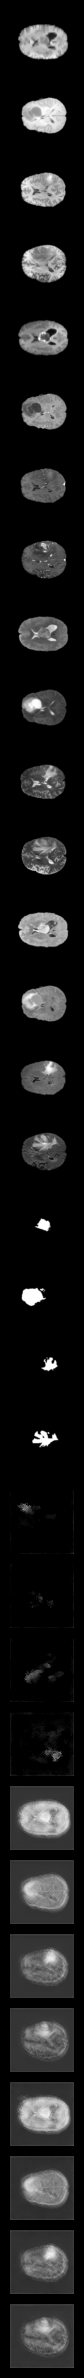

In [32]:
display(Image.open('/kaggle/working/out/brats_val_340_t1_123_w_output0.png'))

In [ ]:
%cd /kaggle/working/out
from IPython.display import FileLink
FileLink('/kaggle/working/out/optsavedmodel000000.pt')

In [ ]:
!tar -cf models.tar /kaggle/working/out

In [ ]:
!ls /kaggle/working/out